In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Scalable Gaussian processes in PyMC3

PyMC3 has support for [Gaussian Processes (GPs)](https://docs.pymc.io/gp.html), but this implementation is too slow for many applications in time series astrophysics.
So *exoplanet* comes with an implementation of scalable GPs powered by [celerite](https://celerite.readthedocs.io/).
More information about the algorithm can be found in the [celerite docs](https://celerite.readthedocs.io/) and in the papers ([Paper 1](https://arxiv.org/abs/1703.09710) and [Paper 2](https://arxiv.org/abs/1801.10156)), but this tutorial will give a hands on demo of how to use celerite in PyMC3.

Let's start with the quickstart demo from the [celerite docs](https://celerite.readthedocs.io/en/stable/tutorials/first/).
We'll fit the following simulated dataset using the sum of two :class:`exoplanet.gp.terms.SHOTerm` objects.

First, generate the simulated data:

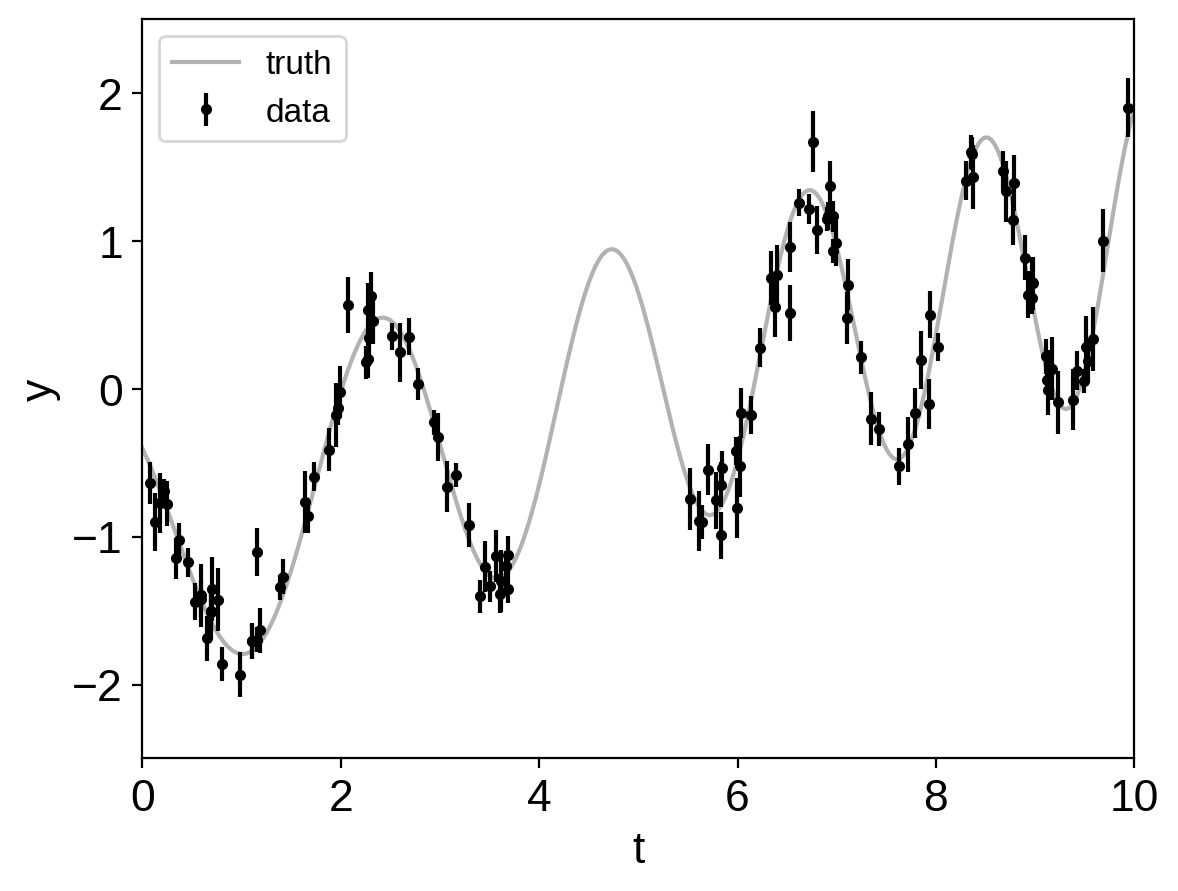

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(np.random.uniform(0, 3.8, 57), np.random.uniform(5.5, 10, 68))
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.legend(fontsize=12)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

This plot shows the simulated data as black points with error bars and
the true function is shown as a gray line.

Now let's build the PyMC3 model that we'll use to fit the data.
We can see that there's some roughly periodic signal in the data as well
as a longer term trend. To capture these two features, we will model
this as a mixture of two stochastically driven simple harmonic
oscillators (SHO) with the power spectrum:

$$
S(\omega) = \sqrt{\frac{2}{\pi}}\frac{S_1\,{\omega_1}^4}{(\omega^2 - {\omega_1}^2)^2 + 2\,{\omega_1}^2\,\omega^2}
   + \sqrt{\frac{2}{\pi}}\frac{S_2\,{\omega_2}^4}{(\omega^2 - {\omega_2}^2)^2 + {\omega_2}^2\,\omega^2/Q^2}
$$

The first term is :class:`exoplanet.gp.terms.SHOterm` with $Q=1/\sqrt{2}$ and the second is regular :class:`exoplanet.gp.terms.SHOterm`.
This model has 5 free parameters ($S_1$, $\omega_1$, $S_2$, $\omega_2$, and $Q$) and they must all be positive so we'll fit for the log of each parameter.
Using *exoplanet*, this is how you would build this model,
choosing more or less arbitrary initial values for the parameters.

In [4]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP

with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma=1.0)
    logS1 = pm.Normal("logS1", mu=0.0, sigma=15.0, testval=np.log(np.var(y)))
    logw1 = pm.Normal("logw1", mu=0.0, sigma=15.0, testval=np.log(3.0))
    logS2 = pm.Normal("logS2", mu=0.0, sigma=15.0, testval=np.log(np.var(y)))
    logw2 = pm.Normal("logw2", mu=0.0, sigma=15.0, testval=np.log(3.0))
    logQ = pm.Normal("logQ", mu=0.0, sigma=15.0, testval=0)

    # Set up the kernel an GP
    kernel = terms.SHOTerm(log_S0=logS1, log_w0=logw1, Q=1.0 / np.sqrt(2))
    kernel += terms.SHOTerm(log_S0=logS2, log_w0=logw2, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2, mean=mean)

    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=y)

A few comments here:

1. The `term` interface in *exoplanet* only accepts keyword arguments with names given by the `parameter_names` property of the term. But it will also interpret keyword arguments with the name prefaced by `log_` to be the log of the parameter. For example, in this case, we used `log_S0` as the parameter for each term, but `S0=tt.exp(log_S0)` would have been equivalent. This is useful because many of the parameters are required to be positive so fitting the log of those parameters is often best.
2. The third argument to the :class:`exoplanet.gp.GP` constructor should be the *variance* to add along the diagonal, not the standard deviation as in the original [celerite implementation](https://celerite.readthedocs.io).
3. Finally, the :class:`exoplanet.gp.GP` constructor takes an optional argument `J` which specifies the width of the problem if it is known at compile time. Just to be confusing, this is actually two times the `J` from [the celerite paper](https://arxiv.org/abs/1703.09710). There are various technical reasons why this is difficult to work out in general and this code will always work if you don't provide a value for `J`, but you can get much better performance (especially for small `J`) if you know what it will be for your problem. In general, most terms cost `J=2` with the exception of a :class:`exoplanet.gp.terms.RealTerm` (which costs `J=1`) and a :class:`exoplanet.gp.terms.RotationTerm` (which costs `J=4`).

To start, let's fit for the maximum a posteriori (MAP) parameters and look the the predictions that those make.

In [5]:
import exoplanet as xo

with model:
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [logQ, logw2, logS2, logw1, logS1, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.198757e+01]

1it [00:00, 270.71it/s, logp=-4.198757e+01]

2it [00:00, 346.06it/s, logp=-1.441157e+01]

3it [00:00, 378.76it/s, logp=-2.672791e+01]

4it [00:00, 398.35it/s, logp=-1.427864e+01]

5it [00:00, 405.71it/s, logp=-1.409530e+01]

6it [00:00, 416.36it/s, logp=-1.805457e+01]

7it [00:00, 424.22it/s, logp=-1.408273e+01]

8it [00:00, 427.71it/s, logp=-1.406092e+01]

9it [00:00, 433.81it/s, logp=-1.403897e+01]

10it [00:00, 441.59it/s, logp=-1.401718e+01]

11it [00:00, 446.79it/s, logp=-1.398992e+01]

12it [00:00, 452.14it/s, logp=-1.369576e+01]

13it [00:00, 457.97it/s, logp=-9.453963e+00]

14it [00:00, 465.88it/s, logp=-1.319547e+01]

15it [00:00, 467.46it/s, logp=-8.622752e+00]

16it [00:00, 467.47it/s, logp=-3.102260e+03]

17it [00:00, 471.05it/s, logp=-1.313021e+03]

18it [00:00, 476.29it/s, logp=-8.622746e+00]

19it [00:00, 476.44it/s, logp=-8.621741e+00]

20it [00:00, 476.17it/s, logp=-8.619706e+00]

21it [00:00, 479.09it/s, logp=-8.611686e+00]

22it [00:00, 481.48it/s, logp=-8.581492e+00]

23it [00:00, 482.32it/s, logp=-8.503609e+00]

24it [00:00, 483.66it/s, logp=-8.255918e+00]

25it [00:00, 481.30it/s, logp=-7.761930e+00]

26it [00:00, 482.38it/s, logp=-6.973377e+00]

27it [00:00, 481.34it/s, logp=-5.886349e+00]

28it [00:00, 480.90it/s, logp=-5.302683e+00]

29it [00:00, 483.19it/s, logp=-4.928781e+00]

30it [00:00, 483.11it/s, logp=-4.644114e+00]

31it [00:00, 483.24it/s, logp=-4.476748e+00]

32it [00:00, 482.45it/s, logp=-4.186807e+00]

33it [00:00, 483.69it/s, logp=-3.780081e+00]

34it [00:00, 482.97it/s, logp=-3.393098e+00]

35it [00:00, 484.13it/s, logp=-3.004002e+00]

36it [00:00, 484.45it/s, logp=-2.776548e+00]

37it [00:00, 482.29it/s, logp=-2.644811e+00]

38it [00:00, 483.09it/s, logp=-2.581257e+00]

39it [00:00, 482.73it/s, logp=-2.571703e+00]

40it [00:00, 483.21it/s, logp=-2.570057e+00]

41it [00:00, 482.53it/s, logp=-2.569910e+00]

42it [00:00, 482.68it/s, logp=-2.569898e+00]

43it [00:00, 483.76it/s, logp=-2.569894e+00]

44it [00:00, 483.92it/s, logp=-2.569893e+00]

45it [00:00, 482.29it/s, logp=-2.569892e+00]

46it [00:00, 482.61it/s, logp=-2.569892e+00]

47it [00:00, 473.59it/s, logp=-2.569892e+00]

48it [00:00, 474.22it/s, logp=-2.569892e+00]

49it [00:00, 480.95it/s, logp=-2.569892e+00]

49it [00:00, 95.18it/s, logp=-2.569892e+00] 


message: Optimization terminated successfully.
logp: -41.9875698144546 -> -2.5698921685733858


We'll use the :func:`exoplanet.eval_in_model` function to evaluate the MAP GP model.

In [6]:
with model:
    mu, var = xo.eval_in_model(gp.predict(true_t, return_var=True), map_soln)

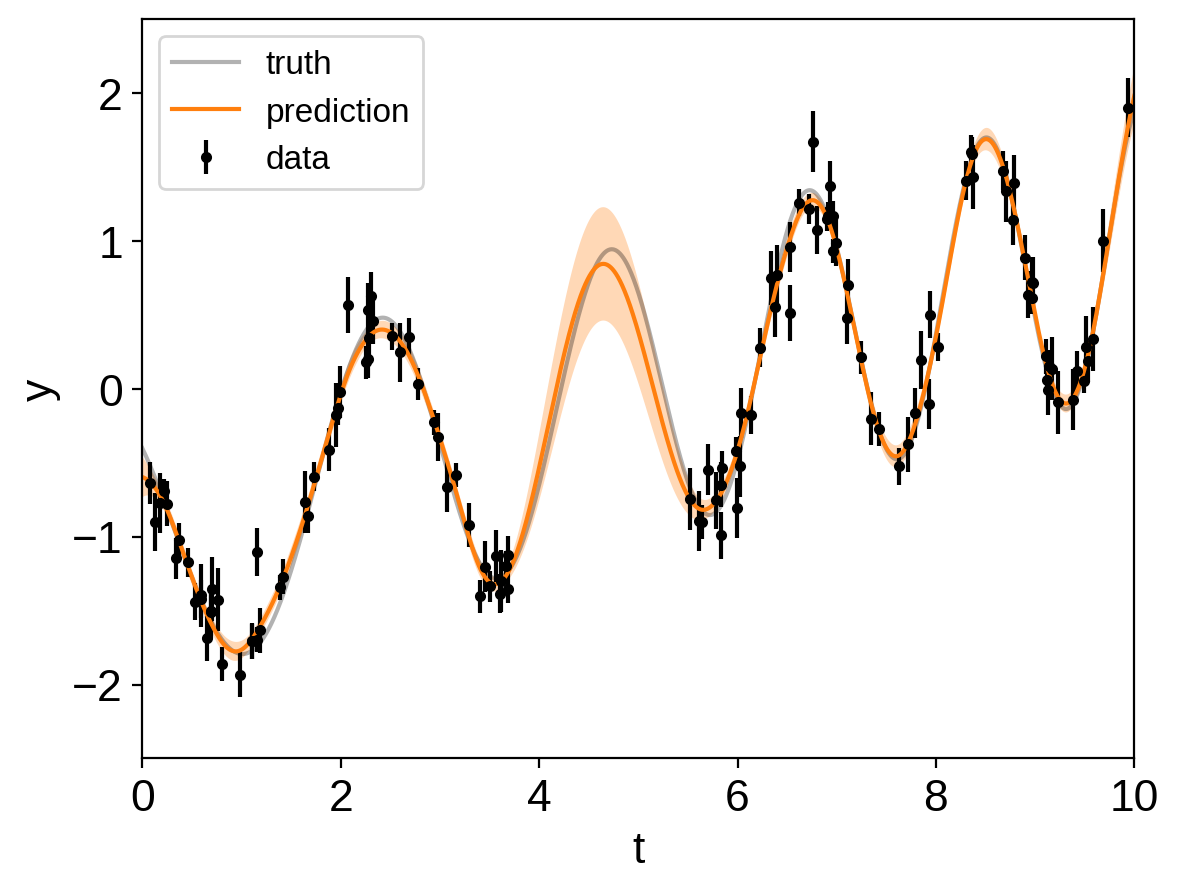

In [7]:
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = plt.fill_between(true_t, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
plt.plot(true_t, mu, color="C1", label="prediction")

plt.legend(fontsize=12)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

Now we can sample this model using PyMC3.
There are strong covariances between the parameters so we'll use the custom :func:`exoplanet.get_dense_nuts_step` to fit for these covariances during burn-in.

In [8]:
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logQ, logw2, logS2, logw1, logS1, mean]


Sampling 2 chains, 0 divergences:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 5/8000 [00:00<05:32, 24.02draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/8000 [00:00<05:59, 22.25draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/8000 [00:00<06:44, 19.74draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 12/8000 [00:00<06:13, 21.40draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 14/8000 [00:00<06:30, 20.47draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/8000 [00:00<06:00, 22.15draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 20/8000 [00:00<05:46, 23.03draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/8000 [00:00<04:37, 28.70draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 31/8000 [00:01<04:19, 30.65draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 35/8000 [00:01<04:35, 28.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 42/8000 [00:01<03:58, 33.35draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 49/8000 [00:01<03:22, 39.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 55/8000 [00:01<03:13, 41.12draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 60/8000 [00:01<03:44, 35.42draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 65/8000 [00:01<03:46, 35.05draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 71/8000 [00:02<03:20, 39.54draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 76/8000 [00:02<04:11, 31.56draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 80/8000 [00:02<04:03, 32.53draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 85/8000 [00:02<03:41, 35.79draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 89/8000 [00:02<03:54, 33.81draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 95/8000 [00:02<03:29, 37.71draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 104/8000 [00:02<02:58, 44.12draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 110/8000 [00:03<03:01, 43.48draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 115/8000 [00:03<02:56, 44.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 120/8000 [00:03<03:19, 39.50draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 128/8000 [00:03<02:56, 44.67draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 139/8000 [00:03<02:26, 53.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 146/8000 [00:03<02:18, 56.58draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 154/8000 [00:03<02:13, 58.93draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 161/8000 [00:03<02:10, 59.85draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 172/8000 [00:03<01:53, 68.77draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 186/8000 [00:04<01:36, 81.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 199/8000 [00:04<01:25, 91.02draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 214/8000 [00:04<01:15, 103.15draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 227/8000 [00:04<01:12, 107.33draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 239/8000 [00:04<01:19, 97.81draws/s] 

Sampling 2 chains, 0 divergences:   3%|▎         | 250/8000 [00:04<01:16, 101.16draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 264/8000 [00:04<01:10, 109.38draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 279/8000 [00:04<01:05, 118.42draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 292/8000 [00:04<01:11, 107.70draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 308/8000 [00:05<01:04, 118.81draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 325/8000 [00:05<00:59, 129.57draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 344/8000 [00:05<00:53, 142.10draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 368/8000 [00:05<00:47, 161.65draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 386/8000 [00:05<00:46, 165.44draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 406/8000 [00:05<00:44, 172.27draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 425/8000 [00:05<00:42, 176.48draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 444/8000 [00:05<00:43, 172.79draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 462/8000 [00:05<00:43, 174.16draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 480/8000 [00:06<00:43, 173.43draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 502/8000 [00:06<00:40, 183.84draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 522/8000 [00:06<00:40, 184.97draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 542/8000 [00:06<00:39, 187.06draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 562/8000 [00:06<00:39, 188.66draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 588/8000 [00:06<00:36, 202.98draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 611/8000 [00:06<00:35, 206.13draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 633/8000 [00:06<00:35, 207.35draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 654/8000 [00:06<00:36, 203.49draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 675/8000 [00:06<00:37, 194.64draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 700/8000 [00:07<00:35, 208.36draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 722/8000 [00:07<00:35, 206.47draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 744/8000 [00:07<00:35, 206.61draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 768/8000 [00:07<00:34, 212.61draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 790/8000 [00:07<00:33, 213.78draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 812/8000 [00:07<00:33, 213.52draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 834/8000 [00:07<00:36, 196.74draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 856/8000 [00:07<00:35, 200.99draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 877/8000 [00:07<00:35, 201.38draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 899/8000 [00:08<00:34, 205.92draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 920/8000 [00:08<00:35, 196.73draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 940/8000 [00:08<00:35, 196.52draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 963/8000 [00:08<00:34, 204.82draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 992/8000 [00:08<00:31, 223.49draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1015/8000 [00:08<00:31, 221.72draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1039/8000 [00:08<00:30, 225.93draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1065/8000 [00:08<00:29, 232.18draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1089/8000 [00:08<00:32, 215.32draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1113/8000 [00:09<00:31, 220.79draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1136/8000 [00:09<00:30, 221.73draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1159/8000 [00:09<00:33, 203.10draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1184/8000 [00:09<00:31, 214.19draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1210/8000 [00:09<00:30, 225.35draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1234/8000 [00:09<00:33, 202.67draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1256/8000 [00:09<00:33, 200.47draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1282/8000 [00:09<00:31, 214.45draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1306/8000 [00:09<00:30, 216.13draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1329/8000 [00:10<00:32, 208.03draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1351/8000 [00:10<00:32, 205.45draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1374/8000 [00:10<00:31, 210.55draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1396/8000 [00:10<00:32, 204.44draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1420/8000 [00:10<00:31, 210.92draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1444/8000 [00:10<00:29, 218.65draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1467/8000 [00:10<00:29, 218.83draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 1493/8000 [00:10<00:28, 227.88draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1516/8000 [00:10<00:28, 227.98draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1539/8000 [00:11<00:29, 221.00draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 1562/8000 [00:11<00:28, 222.86draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 1585/8000 [00:11<00:29, 219.32draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 1608/8000 [00:11<00:31, 202.31draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 1629/8000 [00:11<00:31, 202.22draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1650/8000 [00:11<00:33, 190.88draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1675/8000 [00:11<00:31, 201.84draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1696/8000 [00:11<00:32, 195.22draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1720/8000 [00:11<00:30, 203.65draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1741/8000 [00:12<00:31, 200.65draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1762/8000 [00:12<00:31, 198.15draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1783/8000 [00:12<00:31, 198.33draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1803/8000 [00:12<00:31, 196.21draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1825/8000 [00:12<00:30, 202.29draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1848/8000 [00:12<00:29, 208.34draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1869/8000 [00:12<00:30, 202.21draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 1890/8000 [00:12<00:30, 202.34draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1911/8000 [00:12<00:30, 198.50draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1933/8000 [00:12<00:30, 201.61draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1958/8000 [00:13<00:28, 213.92draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 1983/8000 [00:13<00:27, 221.42draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 2006/8000 [00:13<00:26, 223.00draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 2029/8000 [00:13<00:28, 213.17draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 2055/8000 [00:13<00:26, 222.33draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 2078/8000 [00:13<00:26, 223.70draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 2101/8000 [00:13<00:28, 207.87draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2125/8000 [00:13<00:27, 212.33draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2147/8000 [00:13<00:28, 208.20draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2170/8000 [00:14<00:27, 214.21draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2195/8000 [00:14<00:26, 219.62draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2218/8000 [00:14<00:26, 218.21draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2240/8000 [00:14<00:28, 204.73draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2263/8000 [00:14<00:27, 209.21draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 2285/8000 [00:14<00:26, 212.29draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2308/8000 [00:14<00:26, 216.43draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2333/8000 [00:14<00:25, 223.57draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2356/8000 [00:14<00:25, 223.69draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 2379/8000 [00:15<00:25, 217.22draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 2403/8000 [00:15<00:25, 222.76draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 2426/8000 [00:15<00:25, 216.07draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 2448/8000 [00:15<00:26, 207.79draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 2469/8000 [00:15<00:28, 197.50draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 2489/8000 [00:15<00:28, 193.85draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 2509/8000 [00:15<00:28, 191.99draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2531/8000 [00:15<00:27, 197.49draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2551/8000 [00:15<00:28, 191.30draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2572/8000 [00:16<00:27, 194.96draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2596/8000 [00:16<00:26, 206.40draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2617/8000 [00:16<00:26, 201.68draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2638/8000 [00:16<00:26, 199.69draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2663/8000 [00:16<00:25, 211.36draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 2685/8000 [00:16<00:25, 211.23draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2709/8000 [00:16<00:24, 217.70draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2731/8000 [00:16<00:24, 213.66draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2755/8000 [00:16<00:24, 217.74draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 2779/8000 [00:16<00:23, 221.08draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 2802/8000 [00:17<00:23, 217.85draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 2824/8000 [00:17<00:23, 215.71draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2846/8000 [00:17<00:24, 211.85draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2868/8000 [00:17<00:25, 198.32draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2889/8000 [00:17<00:27, 186.57draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 2909/8000 [00:17<00:27, 187.07draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2932/8000 [00:17<00:25, 195.08draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2955/8000 [00:17<00:25, 201.45draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2977/8000 [00:17<00:24, 206.33draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2998/8000 [00:18<00:24, 204.48draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3019/8000 [00:18<00:25, 197.03draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3039/8000 [00:18<00:25, 191.51draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3059/8000 [00:18<00:25, 192.55draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 3083/8000 [00:18<00:24, 204.68draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 3105/8000 [00:18<00:23, 207.63draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 3126/8000 [00:18<00:23, 204.96draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 3147/8000 [00:18<00:23, 205.67draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 3172/8000 [00:18<00:22, 216.84draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 3194/8000 [00:18<00:22, 215.70draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 3217/8000 [00:19<00:22, 216.86draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 3240/8000 [00:19<00:21, 220.19draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 3263/8000 [00:19<00:22, 210.63draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 3287/8000 [00:19<00:21, 218.20draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 3312/8000 [00:19<00:20, 223.52draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3335/8000 [00:19<00:20, 223.50draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3358/8000 [00:19<00:20, 222.09draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3384/8000 [00:19<00:20, 228.91draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3407/8000 [00:19<00:20, 223.93draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3430/8000 [00:20<00:21, 209.49draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3452/8000 [00:20<00:23, 193.20draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3472/8000 [00:20<00:23, 195.11draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 3492/8000 [00:20<00:23, 193.60draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 3512/8000 [00:20<00:24, 184.34draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 3531/8000 [00:20<00:24, 182.53draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 3551/8000 [00:20<00:23, 185.53draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 3572/8000 [00:20<00:23, 190.48draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 3592/8000 [00:20<00:24, 182.95draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 3614/8000 [00:21<00:22, 190.72draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 3634/8000 [00:21<00:23, 187.27draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 3653/8000 [00:21<00:27, 156.37draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 3670/8000 [00:21<00:32, 132.04draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 3685/8000 [00:21<00:36, 118.35draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 3700/8000 [00:21<00:34, 125.63draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 3717/8000 [00:21<00:31, 135.77draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3732/8000 [00:22<00:32, 130.57draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3746/8000 [00:22<00:34, 122.12draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3764/8000 [00:22<00:32, 132.15draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3778/8000 [00:22<00:31, 133.13draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3793/8000 [00:22<00:30, 136.46draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3809/8000 [00:22<00:29, 140.62draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3824/8000 [00:22<00:30, 138.19draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3839/8000 [00:22<00:29, 141.44draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3854/8000 [00:22<00:29, 141.12draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3871/8000 [00:22<00:28, 146.29draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 3886/8000 [00:23<00:27, 147.31draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 3901/8000 [00:23<00:27, 147.85draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 3917/8000 [00:23<00:27, 146.79draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 3932/8000 [00:23<00:27, 145.44draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 3947/8000 [00:23<00:28, 142.94draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 3962/8000 [00:23<00:28, 141.15draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 3978/8000 [00:23<00:27, 144.17draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 3995/8000 [00:23<00:26, 148.69draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 4010/8000 [00:23<00:28, 140.07draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 4025/8000 [00:24<00:28, 139.65draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 4040/8000 [00:24<00:30, 129.30draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 4054/8000 [00:24<00:30, 127.88draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 4069/8000 [00:24<00:29, 131.85draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 4083/8000 [00:24<00:29, 130.63draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 4098/8000 [00:24<00:29, 131.10draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 4112/8000 [00:24<00:30, 128.97draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4129/8000 [00:24<00:28, 137.71draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4143/8000 [00:24<00:28, 137.74draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4157/8000 [00:25<00:28, 133.31draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4172/8000 [00:25<00:28, 134.68draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4187/8000 [00:25<00:27, 137.66draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4201/8000 [00:25<00:27, 138.18draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4215/8000 [00:25<00:28, 133.91draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4232/8000 [00:25<00:26, 140.70draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4247/8000 [00:25<00:27, 136.62draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4261/8000 [00:25<00:27, 136.53draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4275/8000 [00:25<00:27, 133.26draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 4289/8000 [00:26<00:28, 131.15draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 4304/8000 [00:26<00:28, 130.93draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 4319/8000 [00:26<00:27, 135.47draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 4333/8000 [00:26<00:27, 131.70draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 4349/8000 [00:26<00:26, 138.17draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 4363/8000 [00:26<00:26, 136.74draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 4377/8000 [00:26<00:28, 128.67draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 4392/8000 [00:26<00:26, 134.15draws/s]

Sampling 2 chains, 1 divergences:  55%|█████▍    | 4396/8000 [00:26<00:26, 134.15draws/s]

Sampling 2 chains, 1 divergences:  55%|█████▌    | 4406/8000 [00:26<00:26, 134.95draws/s]

Sampling 2 chains, 1 divergences:  55%|█████▌    | 4421/8000 [00:27<00:26, 135.22draws/s]

Sampling 2 chains, 1 divergences:  55%|█████▌    | 4435/8000 [00:27<00:26, 133.26draws/s]

Sampling 2 chains, 1 divergences:  56%|█████▌    | 4451/8000 [00:27<00:26, 135.81draws/s]

Sampling 2 chains, 1 divergences:  56%|█████▌    | 4469/8000 [00:27<00:24, 142.95draws/s]

Sampling 2 chains, 1 divergences:  56%|█████▌    | 4484/8000 [00:27<00:24, 141.50draws/s]

Sampling 2 chains, 1 divergences:  56%|█████▌    | 4499/8000 [00:27<00:25, 139.18draws/s]

Sampling 2 chains, 1 divergences:  56%|█████▋    | 4513/8000 [00:27<00:25, 134.21draws/s]

Sampling 2 chains, 1 divergences:  57%|█████▋    | 4527/8000 [00:27<00:25, 134.16draws/s]

Sampling 2 chains, 1 divergences:  57%|█████▋    | 4541/8000 [00:27<00:25, 135.34draws/s]

Sampling 2 chains, 1 divergences:  57%|█████▋    | 4556/8000 [00:27<00:25, 136.92draws/s]

Sampling 2 chains, 1 divergences:  57%|█████▋    | 4570/8000 [00:28<00:27, 126.54draws/s]

Sampling 2 chains, 1 divergences:  57%|█████▋    | 4584/8000 [00:28<00:26, 130.10draws/s]

Sampling 2 chains, 1 divergences:  57%|█████▋    | 4598/8000 [00:28<00:26, 128.41draws/s]

Sampling 2 chains, 1 divergences:  58%|█████▊    | 4611/8000 [00:28<00:27, 124.05draws/s]

Sampling 2 chains, 1 divergences:  58%|█████▊    | 4624/8000 [00:28<00:27, 123.35draws/s]

Sampling 2 chains, 1 divergences:  58%|█████▊    | 4637/8000 [00:28<00:27, 121.06draws/s]

Sampling 2 chains, 1 divergences:  58%|█████▊    | 4651/8000 [00:28<00:26, 124.17draws/s]

Sampling 2 chains, 1 divergences:  58%|█████▊    | 4665/8000 [00:28<00:26, 126.45draws/s]

Sampling 2 chains, 1 divergences:  58%|█████▊    | 4680/8000 [00:28<00:25, 132.10draws/s]

Sampling 2 chains, 1 divergences:  59%|█████▊    | 4694/8000 [00:29<00:25, 128.24draws/s]

Sampling 2 chains, 1 divergences:  59%|█████▉    | 4709/8000 [00:29<00:24, 132.43draws/s]

Sampling 2 chains, 2 divergences:  59%|█████▉    | 4718/8000 [00:29<00:24, 132.43draws/s]

Sampling 2 chains, 3 divergences:  59%|█████▉    | 4721/8000 [00:29<00:24, 132.43draws/s]

Sampling 2 chains, 4 divergences:  59%|█████▉    | 4723/8000 [00:29<00:24, 132.43draws/s]

Sampling 2 chains, 4 divergences:  59%|█████▉    | 4724/8000 [00:29<00:23, 136.52draws/s]

Sampling 2 chains, 4 divergences:  59%|█████▉    | 4744/8000 [00:29<00:21, 150.72draws/s]

Sampling 2 chains, 4 divergences:  60%|█████▉    | 4764/8000 [00:29<00:19, 162.74draws/s]

Sampling 2 chains, 4 divergences:  60%|█████▉    | 4781/8000 [00:29<00:20, 157.43draws/s]

Sampling 2 chains, 4 divergences:  60%|██████    | 4800/8000 [00:29<00:19, 164.01draws/s]

Sampling 2 chains, 4 divergences:  60%|██████    | 4817/8000 [00:29<00:19, 164.78draws/s]

Sampling 2 chains, 5 divergences:  60%|██████    | 4834/8000 [00:29<00:19, 164.78draws/s]

Sampling 2 chains, 5 divergences:  60%|██████    | 4835/8000 [00:29<00:18, 167.76draws/s]

Sampling 2 chains, 5 divergences:  61%|██████    | 4852/8000 [00:30<00:19, 162.35draws/s]

Sampling 2 chains, 6 divergences:  61%|██████    | 4856/8000 [00:30<00:19, 162.35draws/s]

Sampling 2 chains, 7 divergences:  61%|██████    | 4857/8000 [00:30<00:19, 162.35draws/s]

Sampling 2 chains, 7 divergences:  61%|██████    | 4869/8000 [00:30<00:20, 153.46draws/s]

Sampling 2 chains, 8 divergences:  61%|██████    | 4883/8000 [00:30<00:20, 153.46draws/s]

Sampling 2 chains, 8 divergences:  61%|██████    | 4887/8000 [00:30<00:19, 156.98draws/s]

Sampling 2 chains, 9 divergences:  61%|██████    | 4897/8000 [00:30<00:19, 156.98draws/s]

Sampling 2 chains, 9 divergences:  61%|██████▏   | 4907/8000 [00:30<00:18, 167.24draws/s]

Sampling 2 chains, 10 divergences:  61%|██████▏   | 4917/8000 [00:30<00:18, 167.24draws/s]

Sampling 2 chains, 11 divergences:  62%|██████▏   | 4921/8000 [00:30<00:18, 167.24draws/s]

Sampling 2 chains, 11 divergences:  62%|██████▏   | 4925/8000 [00:30<00:18, 168.39draws/s]

Sampling 2 chains, 12 divergences:  62%|██████▏   | 4930/8000 [00:30<00:18, 168.39draws/s]

Sampling 2 chains, 12 divergences:  62%|██████▏   | 4943/8000 [00:30<00:18, 164.93draws/s]

Sampling 2 chains, 12 divergences:  62%|██████▏   | 4965/8000 [00:30<00:17, 176.54draws/s]

Sampling 2 chains, 13 divergences:  62%|██████▏   | 4971/8000 [00:30<00:17, 176.54draws/s]

Sampling 2 chains, 14 divergences:  62%|██████▏   | 4980/8000 [00:30<00:17, 176.54draws/s]

Sampling 2 chains, 14 divergences:  62%|██████▏   | 4985/8000 [00:30<00:16, 181.16draws/s]

Sampling 2 chains, 15 divergences:  62%|██████▏   | 4995/8000 [00:30<00:16, 181.16draws/s]

Sampling 2 chains, 15 divergences:  63%|██████▎   | 5005/8000 [00:30<00:16, 185.51draws/s]

Sampling 2 chains, 16 divergences:  63%|██████▎   | 5018/8000 [00:30<00:16, 185.51draws/s]

Sampling 2 chains, 17 divergences:  63%|██████▎   | 5021/8000 [00:31<00:16, 185.51draws/s]

Sampling 2 chains, 17 divergences:  63%|██████▎   | 5024/8000 [00:31<00:16, 181.79draws/s]

Sampling 2 chains, 18 divergences:  63%|██████▎   | 5029/8000 [00:31<00:16, 181.79draws/s]

Sampling 2 chains, 18 divergences:  63%|██████▎   | 5043/8000 [00:31<00:16, 180.51draws/s]

Sampling 2 chains, 18 divergences:  63%|██████▎   | 5062/8000 [00:31<00:16, 180.68draws/s]

Sampling 2 chains, 18 divergences:  64%|██████▎   | 5081/8000 [00:31<00:16, 181.12draws/s]

Sampling 2 chains, 19 divergences:  64%|██████▎   | 5081/8000 [00:31<00:16, 181.12draws/s]

Sampling 2 chains, 19 divergences:  64%|██████▍   | 5100/8000 [00:31<00:16, 179.77draws/s]

Sampling 2 chains, 19 divergences:  64%|██████▍   | 5119/8000 [00:31<00:16, 176.41draws/s]

Sampling 2 chains, 20 divergences:  64%|██████▍   | 5126/8000 [00:31<00:16, 176.41draws/s]

Sampling 2 chains, 21 divergences:  64%|██████▍   | 5135/8000 [00:31<00:16, 176.41draws/s]

Sampling 2 chains, 21 divergences:  64%|██████▍   | 5137/8000 [00:31<00:16, 170.71draws/s]

Sampling 2 chains, 21 divergences:  64%|██████▍   | 5155/8000 [00:31<00:17, 162.92draws/s]

Sampling 2 chains, 21 divergences:  65%|██████▍   | 5172/8000 [00:31<00:18, 156.64draws/s]

Sampling 2 chains, 21 divergences:  65%|██████▍   | 5190/8000 [00:32<00:17, 159.96draws/s]

Sampling 2 chains, 21 divergences:  65%|██████▌   | 5207/8000 [00:32<00:17, 158.30draws/s]

Sampling 2 chains, 21 divergences:  65%|██████▌   | 5226/8000 [00:32<00:16, 164.33draws/s]

Sampling 2 chains, 21 divergences:  66%|██████▌   | 5243/8000 [00:32<00:17, 157.75draws/s]

Sampling 2 chains, 22 divergences:  66%|██████▌   | 5255/8000 [00:32<00:17, 157.75draws/s]

Sampling 2 chains, 22 divergences:  66%|██████▌   | 5259/8000 [00:32<00:17, 155.27draws/s]

Sampling 2 chains, 22 divergences:  66%|██████▌   | 5275/8000 [00:32<00:17, 156.00draws/s]

Sampling 2 chains, 22 divergences:  66%|██████▌   | 5291/8000 [00:32<00:17, 152.30draws/s]

Sampling 2 chains, 22 divergences:  66%|██████▋   | 5307/8000 [00:32<00:19, 141.49draws/s]

Sampling 2 chains, 23 divergences:  66%|██████▋   | 5318/8000 [00:32<00:18, 141.49draws/s]

Sampling 2 chains, 23 divergences:  67%|██████▋   | 5322/8000 [00:32<00:20, 130.36draws/s]

Sampling 2 chains, 23 divergences:  67%|██████▋   | 5336/8000 [00:33<00:23, 113.40draws/s]

Sampling 2 chains, 24 divergences:  67%|██████▋   | 5343/8000 [00:33<00:23, 113.40draws/s]

Sampling 2 chains, 24 divergences:  67%|██████▋   | 5349/8000 [00:33<00:23, 114.82draws/s]

Sampling 2 chains, 24 divergences:  67%|██████▋   | 5368/8000 [00:33<00:20, 128.72draws/s]

Sampling 2 chains, 25 divergences:  67%|██████▋   | 5381/8000 [00:33<00:20, 128.72draws/s]

Sampling 2 chains, 25 divergences:  67%|██████▋   | 5382/8000 [00:33<00:21, 123.05draws/s]

Sampling 2 chains, 25 divergences:  67%|██████▋   | 5395/8000 [00:33<00:22, 116.13draws/s]

Sampling 2 chains, 26 divergences:  67%|██████▋   | 5398/8000 [00:33<00:22, 116.13draws/s]

Sampling 2 chains, 27 divergences:  68%|██████▊   | 5402/8000 [00:33<00:22, 116.13draws/s]

Sampling 2 chains, 27 divergences:  68%|██████▊   | 5412/8000 [00:33<00:20, 128.02draws/s]

Sampling 2 chains, 28 divergences:  68%|██████▊   | 5421/8000 [00:33<00:20, 128.02draws/s]

Sampling 2 chains, 28 divergences:  68%|██████▊   | 5426/8000 [00:33<00:21, 122.22draws/s]

Sampling 2 chains, 28 divergences:  68%|██████▊   | 5439/8000 [00:33<00:22, 114.54draws/s]

Sampling 2 chains, 29 divergences:  68%|██████▊   | 5446/8000 [00:33<00:22, 114.54draws/s]

Sampling 2 chains, 29 divergences:  68%|██████▊   | 5453/8000 [00:34<00:21, 120.66draws/s]

Sampling 2 chains, 29 divergences:  68%|██████▊   | 5466/8000 [00:34<00:22, 114.30draws/s]

Sampling 2 chains, 30 divergences:  68%|██████▊   | 5477/8000 [00:34<00:22, 114.30draws/s]

Sampling 2 chains, 30 divergences:  68%|██████▊   | 5478/8000 [00:34<00:22, 110.01draws/s]

Sampling 2 chains, 30 divergences:  69%|██████▊   | 5490/8000 [00:34<00:22, 110.06draws/s]

Sampling 2 chains, 31 divergences:  69%|██████▊   | 5490/8000 [00:34<00:22, 110.06draws/s]

Sampling 2 chains, 31 divergences:  69%|██████▉   | 5506/8000 [00:34<00:21, 118.50draws/s]

Sampling 2 chains, 31 divergences:  69%|██████▉   | 5519/8000 [00:34<00:22, 108.26draws/s]

Sampling 2 chains, 31 divergences:  69%|██████▉   | 5533/8000 [00:34<00:21, 114.60draws/s]

Sampling 2 chains, 31 divergences:  69%|██████▉   | 5546/8000 [00:34<00:20, 117.33draws/s]

Sampling 2 chains, 31 divergences:  69%|██████▉   | 5559/8000 [00:34<00:22, 106.94draws/s]

Sampling 2 chains, 31 divergences:  70%|██████▉   | 5571/8000 [00:35<00:22, 106.85draws/s]

Sampling 2 chains, 32 divergences:  70%|██████▉   | 5579/8000 [00:35<00:22, 106.85draws/s]

Sampling 2 chains, 32 divergences:  70%|██████▉   | 5588/8000 [00:35<00:20, 119.02draws/s]

Sampling 2 chains, 33 divergences:  70%|██████▉   | 5598/8000 [00:35<00:20, 119.02draws/s]

Sampling 2 chains, 33 divergences:  70%|███████   | 5605/8000 [00:35<00:18, 129.87draws/s]

Sampling 2 chains, 33 divergences:  70%|███████   | 5622/8000 [00:35<00:17, 137.72draws/s]

Sampling 2 chains, 34 divergences:  70%|███████   | 5623/8000 [00:35<00:17, 137.72draws/s]

Sampling 2 chains, 35 divergences:  70%|███████   | 5629/8000 [00:35<00:17, 137.72draws/s]

Sampling 2 chains, 35 divergences:  71%|███████   | 5643/8000 [00:35<00:15, 152.35draws/s]

Sampling 2 chains, 36 divergences:  71%|███████   | 5644/8000 [00:35<00:15, 152.35draws/s]

Sampling 2 chains, 37 divergences:  71%|███████   | 5651/8000 [00:35<00:15, 152.35draws/s]

Sampling 2 chains, 37 divergences:  71%|███████   | 5661/8000 [00:35<00:14, 158.99draws/s]

Sampling 2 chains, 37 divergences:  71%|███████   | 5679/8000 [00:35<00:14, 164.02draws/s]

Sampling 2 chains, 37 divergences:  71%|███████   | 5696/8000 [00:35<00:14, 157.39draws/s]

Sampling 2 chains, 37 divergences:  71%|███████▏  | 5713/8000 [00:35<00:15, 150.43draws/s]

Sampling 2 chains, 37 divergences:  72%|███████▏  | 5730/8000 [00:36<00:14, 154.77draws/s]

Sampling 2 chains, 38 divergences:  72%|███████▏  | 5740/8000 [00:36<00:14, 154.77draws/s]

Sampling 2 chains, 39 divergences:  72%|███████▏  | 5742/8000 [00:36<00:14, 154.77draws/s]

Sampling 2 chains, 40 divergences:  72%|███████▏  | 5744/8000 [00:36<00:14, 154.77draws/s]

Sampling 2 chains, 40 divergences:  72%|███████▏  | 5748/8000 [00:36<00:13, 160.94draws/s]

Sampling 2 chains, 40 divergences:  72%|███████▏  | 5766/8000 [00:36<00:13, 163.02draws/s]

Sampling 2 chains, 41 divergences:  72%|███████▏  | 5775/8000 [00:36<00:13, 163.02draws/s]

Sampling 2 chains, 42 divergences:  72%|███████▏  | 5781/8000 [00:36<00:13, 163.02draws/s]

Sampling 2 chains, 43 divergences:  72%|███████▏  | 5782/8000 [00:36<00:13, 163.02draws/s]

Sampling 2 chains, 43 divergences:  72%|███████▏  | 5784/8000 [00:36<00:13, 166.84draws/s]

Sampling 2 chains, 44 divergences:  72%|███████▏  | 5789/8000 [00:36<00:13, 166.84draws/s]

Sampling 2 chains, 44 divergences:  73%|███████▎  | 5804/8000 [00:36<00:12, 175.27draws/s]

Sampling 2 chains, 45 divergences:  73%|███████▎  | 5817/8000 [00:36<00:12, 175.27draws/s]

Sampling 2 chains, 45 divergences:  73%|███████▎  | 5822/8000 [00:36<00:12, 175.41draws/s]

Sampling 2 chains, 46 divergences:  73%|███████▎  | 5824/8000 [00:36<00:12, 175.41draws/s]

Sampling 2 chains, 46 divergences:  73%|███████▎  | 5840/8000 [00:36<00:12, 174.03draws/s]

Sampling 2 chains, 47 divergences:  73%|███████▎  | 5844/8000 [00:36<00:12, 174.03draws/s]

Sampling 2 chains, 47 divergences:  73%|███████▎  | 5859/8000 [00:36<00:12, 177.00draws/s]

Sampling 2 chains, 48 divergences:  73%|███████▎  | 5870/8000 [00:36<00:12, 177.00draws/s]

Sampling 2 chains, 48 divergences:  73%|███████▎  | 5877/8000 [00:36<00:12, 176.36draws/s]

Sampling 2 chains, 49 divergences:  73%|███████▎  | 5879/8000 [00:36<00:12, 176.36draws/s]

Sampling 2 chains, 49 divergences:  74%|███████▎  | 5897/8000 [00:37<00:11, 179.79draws/s]

Sampling 2 chains, 50 divergences:  74%|███████▍  | 5905/8000 [00:37<00:11, 179.79draws/s]

Sampling 2 chains, 51 divergences:  74%|███████▍  | 5911/8000 [00:37<00:11, 179.79draws/s]

Sampling 2 chains, 51 divergences:  74%|███████▍  | 5916/8000 [00:37<00:12, 168.50draws/s]

Sampling 2 chains, 51 divergences:  74%|███████▍  | 5937/8000 [00:37<00:11, 178.23draws/s]

Sampling 2 chains, 51 divergences:  74%|███████▍  | 5958/8000 [00:37<00:11, 184.13draws/s]

Sampling 2 chains, 51 divergences:  75%|███████▍  | 5977/8000 [00:37<00:11, 178.31draws/s]

Sampling 2 chains, 52 divergences:  75%|███████▍  | 5977/8000 [00:37<00:11, 178.31draws/s]

Sampling 2 chains, 53 divergences:  75%|███████▍  | 5979/8000 [00:37<00:11, 178.31draws/s]

Sampling 2 chains, 54 divergences:  75%|███████▍  | 5990/8000 [00:37<00:11, 178.31draws/s]

Sampling 2 chains, 54 divergences:  75%|███████▍  | 5996/8000 [00:37<00:11, 171.23draws/s]

Sampling 2 chains, 55 divergences:  75%|███████▌  | 6008/8000 [00:37<00:11, 171.23draws/s]

Sampling 2 chains, 55 divergences:  75%|███████▌  | 6015/8000 [00:37<00:11, 175.80draws/s]

Sampling 2 chains, 56 divergences:  75%|███████▌  | 6023/8000 [00:37<00:11, 175.80draws/s]

Sampling 2 chains, 56 divergences:  75%|███████▌  | 6033/8000 [00:37<00:11, 176.59draws/s]

Sampling 2 chains, 56 divergences:  76%|███████▌  | 6052/8000 [00:37<00:10, 179.98draws/s]

Sampling 2 chains, 56 divergences:  76%|███████▌  | 6071/8000 [00:37<00:11, 175.33draws/s]

Sampling 2 chains, 56 divergences:  76%|███████▌  | 6089/8000 [00:38<00:10, 173.94draws/s]

Sampling 2 chains, 56 divergences:  76%|███████▋  | 6107/8000 [00:38<00:11, 168.25draws/s]

Sampling 2 chains, 56 divergences:  77%|███████▋  | 6124/8000 [00:38<00:11, 160.24draws/s]

Sampling 2 chains, 57 divergences:  77%|███████▋  | 6133/8000 [00:38<00:11, 160.24draws/s]

Sampling 2 chains, 57 divergences:  77%|███████▋  | 6141/8000 [00:38<00:11, 159.25draws/s]

Sampling 2 chains, 57 divergences:  77%|███████▋  | 6158/8000 [00:38<00:11, 157.52draws/s]

Sampling 2 chains, 57 divergences:  77%|███████▋  | 6177/8000 [00:38<00:11, 164.53draws/s]

Sampling 2 chains, 57 divergences:  77%|███████▋  | 6194/8000 [00:38<00:11, 160.23draws/s]

Sampling 2 chains, 57 divergences:  78%|███████▊  | 6211/8000 [00:38<00:11, 153.17draws/s]

Sampling 2 chains, 57 divergences:  78%|███████▊  | 6227/8000 [00:39<00:12, 146.91draws/s]

Sampling 2 chains, 57 divergences:  78%|███████▊  | 6244/8000 [00:39<00:11, 152.17draws/s]

Sampling 2 chains, 57 divergences:  78%|███████▊  | 6260/8000 [00:39<00:11, 153.53draws/s]

Sampling 2 chains, 57 divergences:  78%|███████▊  | 6276/8000 [00:39<00:11, 154.11draws/s]

Sampling 2 chains, 57 divergences:  79%|███████▊  | 6295/8000 [00:39<00:10, 161.15draws/s]

Sampling 2 chains, 58 divergences:  79%|███████▉  | 6301/8000 [00:39<00:10, 161.15draws/s]

Sampling 2 chains, 59 divergences:  79%|███████▉  | 6306/8000 [00:39<00:10, 161.15draws/s]

Sampling 2 chains, 59 divergences:  79%|███████▉  | 6312/8000 [00:39<00:10, 162.75draws/s]

Sampling 2 chains, 60 divergences:  79%|███████▉  | 6314/8000 [00:39<00:10, 162.75draws/s]

Sampling 2 chains, 60 divergences:  79%|███████▉  | 6329/8000 [00:39<00:10, 161.75draws/s]

Sampling 2 chains, 61 divergences:  79%|███████▉  | 6344/8000 [00:39<00:10, 161.75draws/s]

Sampling 2 chains, 61 divergences:  79%|███████▉  | 6346/8000 [00:39<00:10, 162.46draws/s]

Sampling 2 chains, 61 divergences:  80%|███████▉  | 6365/8000 [00:39<00:09, 167.06draws/s]

Sampling 2 chains, 61 divergences:  80%|███████▉  | 6382/8000 [00:39<00:09, 166.73draws/s]

Sampling 2 chains, 61 divergences:  80%|███████▉  | 6399/8000 [00:40<00:10, 158.55draws/s]

Sampling 2 chains, 61 divergences:  80%|████████  | 6418/8000 [00:40<00:09, 165.97draws/s]

Sampling 2 chains, 62 divergences:  80%|████████  | 6428/8000 [00:40<00:09, 165.97draws/s]

Sampling 2 chains, 62 divergences:  80%|████████  | 6435/8000 [00:40<00:09, 164.17draws/s]

Sampling 2 chains, 63 divergences:  80%|████████  | 6435/8000 [00:40<00:09, 164.17draws/s]

Sampling 2 chains, 64 divergences:  81%|████████  | 6445/8000 [00:40<00:09, 164.17draws/s]

Sampling 2 chains, 64 divergences:  81%|████████  | 6452/8000 [00:40<00:09, 154.94draws/s]

Sampling 2 chains, 64 divergences:  81%|████████  | 6470/8000 [00:40<00:09, 159.11draws/s]

Sampling 2 chains, 65 divergences:  81%|████████  | 6474/8000 [00:40<00:09, 159.11draws/s]

Sampling 2 chains, 65 divergences:  81%|████████  | 6488/8000 [00:40<00:09, 163.90draws/s]

Sampling 2 chains, 66 divergences:  81%|████████  | 6489/8000 [00:40<00:09, 163.90draws/s]

Sampling 2 chains, 66 divergences:  81%|████████▏ | 6505/8000 [00:40<00:09, 165.00draws/s]

Sampling 2 chains, 67 divergences:  82%|████████▏ | 6521/8000 [00:40<00:08, 165.00draws/s]

Sampling 2 chains, 67 divergences:  82%|████████▏ | 6522/8000 [00:40<00:08, 165.80draws/s]

Sampling 2 chains, 68 divergences:  82%|████████▏ | 6523/8000 [00:40<00:08, 165.80draws/s]

Sampling 2 chains, 69 divergences:  82%|████████▏ | 6529/8000 [00:40<00:08, 165.80draws/s]

Sampling 2 chains, 69 divergences:  82%|████████▏ | 6539/8000 [00:40<00:09, 156.83draws/s]

Sampling 2 chains, 69 divergences:  82%|████████▏ | 6558/8000 [00:41<00:08, 164.13draws/s]

Sampling 2 chains, 69 divergences:  82%|████████▏ | 6575/8000 [00:41<00:09, 158.19draws/s]

Sampling 2 chains, 69 divergences:  82%|████████▏ | 6594/8000 [00:41<00:08, 164.47draws/s]

Sampling 2 chains, 70 divergences:  83%|████████▎ | 6602/8000 [00:41<00:08, 164.47draws/s]

Sampling 2 chains, 70 divergences:  83%|████████▎ | 6611/8000 [00:41<00:09, 153.48draws/s]

Sampling 2 chains, 70 divergences:  83%|████████▎ | 6627/8000 [00:41<00:08, 154.69draws/s]

Sampling 2 chains, 70 divergences:  83%|████████▎ | 6646/8000 [00:41<00:08, 162.19draws/s]

Sampling 2 chains, 70 divergences:  83%|████████▎ | 6663/8000 [00:41<00:08, 161.51draws/s]

Sampling 2 chains, 71 divergences:  83%|████████▎ | 6672/8000 [00:41<00:08, 161.51draws/s]

Sampling 2 chains, 71 divergences:  84%|████████▎ | 6680/8000 [00:41<00:08, 161.00draws/s]

Sampling 2 chains, 72 divergences:  84%|████████▎ | 6684/8000 [00:41<00:08, 161.00draws/s]

Sampling 2 chains, 72 divergences:  84%|████████▍ | 6700/8000 [00:41<00:07, 169.02draws/s]

Sampling 2 chains, 73 divergences:  84%|████████▍ | 6700/8000 [00:41<00:07, 169.02draws/s]

Sampling 2 chains, 74 divergences:  84%|████████▍ | 6701/8000 [00:41<00:07, 169.02draws/s]

Sampling 2 chains, 74 divergences:  84%|████████▍ | 6719/8000 [00:42<00:07, 168.15draws/s]

Sampling 2 chains, 75 divergences:  84%|████████▍ | 6730/8000 [00:42<00:07, 168.15draws/s]

Sampling 2 chains, 75 divergences:  84%|████████▍ | 6738/8000 [00:42<00:07, 172.07draws/s]

Sampling 2 chains, 75 divergences:  84%|████████▍ | 6756/8000 [00:42<00:07, 173.41draws/s]

Sampling 2 chains, 75 divergences:  85%|████████▍ | 6774/8000 [00:42<00:07, 171.50draws/s]

Sampling 2 chains, 76 divergences:  85%|████████▍ | 6780/8000 [00:42<00:07, 171.50draws/s]

Sampling 2 chains, 76 divergences:  85%|████████▍ | 6792/8000 [00:42<00:07, 165.93draws/s]

Sampling 2 chains, 76 divergences:  85%|████████▌ | 6809/8000 [00:42<00:07, 159.70draws/s]

Sampling 2 chains, 76 divergences:  85%|████████▌ | 6828/8000 [00:42<00:07, 165.22draws/s]

Sampling 2 chains, 76 divergences:  86%|████████▌ | 6845/8000 [00:42<00:07, 163.93draws/s]

Sampling 2 chains, 76 divergences:  86%|████████▌ | 6868/8000 [00:42<00:06, 178.15draws/s]

Sampling 2 chains, 77 divergences:  86%|████████▌ | 6884/8000 [00:42<00:06, 178.15draws/s]

Sampling 2 chains, 77 divergences:  86%|████████▌ | 6887/8000 [00:42<00:06, 176.67draws/s]

Sampling 2 chains, 77 divergences:  86%|████████▋ | 6907/8000 [00:43<00:06, 181.63draws/s]

Sampling 2 chains, 77 divergences:  87%|████████▋ | 6926/8000 [00:43<00:06, 176.02draws/s]

Sampling 2 chains, 78 divergences:  87%|████████▋ | 6933/8000 [00:43<00:06, 176.02draws/s]

Sampling 2 chains, 78 divergences:  87%|████████▋ | 6944/8000 [00:43<00:05, 176.81draws/s]

Sampling 2 chains, 78 divergences:  87%|████████▋ | 6962/8000 [00:43<00:06, 171.37draws/s]

Sampling 2 chains, 79 divergences:  87%|████████▋ | 6962/8000 [00:43<00:06, 171.37draws/s]

Sampling 2 chains, 80 divergences:  87%|████████▋ | 6978/8000 [00:43<00:05, 171.37draws/s]

Sampling 2 chains, 80 divergences:  87%|████████▋ | 6983/8000 [00:43<00:05, 179.80draws/s]

Sampling 2 chains, 81 divergences:  87%|████████▋ | 6987/8000 [00:43<00:05, 179.80draws/s]

Sampling 2 chains, 82 divergences:  87%|████████▋ | 6988/8000 [00:43<00:05, 179.80draws/s]

Sampling 2 chains, 83 divergences:  87%|████████▋ | 6992/8000 [00:43<00:05, 179.80draws/s]

Sampling 2 chains, 84 divergences:  87%|████████▋ | 6994/8000 [00:43<00:05, 179.80draws/s]

Sampling 2 chains, 84 divergences:  88%|████████▊ | 7002/8000 [00:43<00:07, 140.65draws/s]

Sampling 2 chains, 85 divergences:  88%|████████▊ | 7016/8000 [00:43<00:06, 140.65draws/s]

Sampling 2 chains, 86 divergences:  88%|████████▊ | 7017/8000 [00:43<00:06, 140.65draws/s]

Sampling 2 chains, 86 divergences:  88%|████████▊ | 7018/8000 [00:43<00:09, 102.46draws/s]

Sampling 2 chains, 87 divergences:  88%|████████▊ | 7025/8000 [00:44<00:09, 102.46draws/s]

Sampling 2 chains, 88 divergences:  88%|████████▊ | 7026/8000 [00:44<00:09, 102.46draws/s]

Sampling 2 chains, 89 divergences:  88%|████████▊ | 7030/8000 [00:44<00:09, 102.46draws/s]

Sampling 2 chains, 89 divergences:  88%|████████▊ | 7031/8000 [00:44<00:10, 89.38draws/s] 

Sampling 2 chains, 90 divergences:  88%|████████▊ | 7039/8000 [00:44<00:10, 89.38draws/s]

Sampling 2 chains, 91 divergences:  88%|████████▊ | 7042/8000 [00:44<00:10, 89.38draws/s]

Sampling 2 chains, 92 divergences:  88%|████████▊ | 7046/8000 [00:44<00:10, 89.38draws/s]

Sampling 2 chains, 92 divergences:  88%|████████▊ | 7047/8000 [00:44<00:09, 102.93draws/s]

Sampling 2 chains, 93 divergences:  88%|████████▊ | 7049/8000 [00:44<00:09, 102.93draws/s]

Sampling 2 chains, 94 divergences:  88%|████████▊ | 7053/8000 [00:44<00:09, 102.93draws/s]

Sampling 2 chains, 94 divergences:  88%|████████▊ | 7060/8000 [00:44<00:09, 97.85draws/s] 

Sampling 2 chains, 95 divergences:  88%|████████▊ | 7064/8000 [00:44<00:09, 97.85draws/s]

Sampling 2 chains, 95 divergences:  88%|████████▊ | 7072/8000 [00:44<00:09, 97.48draws/s]

Sampling 2 chains, 96 divergences:  88%|████████▊ | 7076/8000 [00:44<00:09, 97.48draws/s]

Sampling 2 chains, 97 divergences:  88%|████████▊ | 7078/8000 [00:44<00:09, 97.48draws/s]

Sampling 2 chains, 97 divergences:  89%|████████▊ | 7083/8000 [00:44<00:09, 93.63draws/s]

Sampling 2 chains, 98 divergences:  89%|████████▊ | 7083/8000 [00:44<00:09, 93.63draws/s]

Sampling 2 chains, 98 divergences:  89%|████████▊ | 7094/8000 [00:44<00:11, 79.63draws/s]

Sampling 2 chains, 98 divergences:  89%|████████▉ | 7105/8000 [00:44<00:10, 85.61draws/s]

Sampling 2 chains, 99 divergences:  89%|████████▉ | 7106/8000 [00:44<00:10, 85.61draws/s]

Sampling 2 chains, 99 divergences:  89%|████████▉ | 7115/8000 [00:45<00:11, 77.95draws/s]

Sampling 2 chains, 100 divergences:  89%|████████▉ | 7120/8000 [00:45<00:11, 77.95draws/s]

Sampling 2 chains, 100 divergences:  89%|████████▉ | 7124/8000 [00:45<00:10, 81.08draws/s]

Sampling 2 chains, 101 divergences:  89%|████████▉ | 7131/8000 [00:45<00:10, 81.08draws/s]

Sampling 2 chains, 101 divergences:  89%|████████▉ | 7133/8000 [00:45<00:11, 77.99draws/s]

Sampling 2 chains, 101 divergences:  89%|████████▉ | 7142/8000 [00:45<00:11, 76.51draws/s]

Sampling 2 chains, 102 divergences:  89%|████████▉ | 7149/8000 [00:45<00:11, 76.51draws/s]

Sampling 2 chains, 103 divergences:  89%|████████▉ | 7150/8000 [00:45<00:11, 76.51draws/s]

Sampling 2 chains, 103 divergences:  89%|████████▉ | 7152/8000 [00:45<00:10, 82.19draws/s]

Sampling 2 chains, 104 divergences:  89%|████████▉ | 7152/8000 [00:45<00:10, 82.19draws/s]

Sampling 2 chains, 105 divergences:  89%|████████▉ | 7155/8000 [00:45<00:10, 82.19draws/s]

Sampling 2 chains, 106 divergences:  89%|████████▉ | 7157/8000 [00:45<00:10, 82.19draws/s]

Sampling 2 chains, 106 divergences:  90%|████████▉ | 7161/8000 [00:45<00:10, 81.44draws/s]

Sampling 2 chains, 106 divergences:  90%|████████▉ | 7170/8000 [00:45<00:10, 80.31draws/s]

Sampling 2 chains, 106 divergences:  90%|████████▉ | 7179/8000 [00:45<00:10, 81.21draws/s]

Sampling 2 chains, 107 divergences:  90%|████████▉ | 7180/8000 [00:45<00:10, 81.21draws/s]

Sampling 2 chains, 107 divergences:  90%|████████▉ | 7188/8000 [00:46<00:11, 73.43draws/s]

Sampling 2 chains, 107 divergences:  90%|████████▉ | 7197/8000 [00:46<00:10, 76.52draws/s]

Sampling 2 chains, 107 divergences:  90%|█████████ | 7205/8000 [00:46<00:10, 73.26draws/s]

Sampling 2 chains, 108 divergences:  90%|█████████ | 7208/8000 [00:46<00:10, 73.26draws/s]

Sampling 2 chains, 108 divergences:  90%|█████████ | 7215/8000 [00:46<00:10, 77.74draws/s]

Sampling 2 chains, 108 divergences:  90%|█████████ | 7224/8000 [00:46<00:09, 79.49draws/s]

Sampling 2 chains, 109 divergences:  90%|█████████ | 7225/8000 [00:46<00:09, 79.49draws/s]

Sampling 2 chains, 110 divergences:  90%|█████████ | 7230/8000 [00:46<00:09, 79.49draws/s]

Sampling 2 chains, 111 divergences:  90%|█████████ | 7233/8000 [00:46<00:09, 79.49draws/s]

Sampling 2 chains, 111 divergences:  90%|█████████ | 7234/8000 [00:46<00:09, 82.99draws/s]

Sampling 2 chains, 112 divergences:  91%|█████████ | 7243/8000 [00:46<00:09, 82.99draws/s]

Sampling 2 chains, 112 divergences:  91%|█████████ | 7244/8000 [00:46<00:08, 87.41draws/s]

Sampling 2 chains, 112 divergences:  91%|█████████ | 7253/8000 [00:46<00:08, 87.05draws/s]

Sampling 2 chains, 113 divergences:  91%|█████████ | 7255/8000 [00:46<00:08, 87.05draws/s]

Sampling 2 chains, 114 divergences:  91%|█████████ | 7260/8000 [00:46<00:08, 87.05draws/s]

Sampling 2 chains, 114 divergences:  91%|█████████ | 7262/8000 [00:46<00:08, 84.60draws/s]

Sampling 2 chains, 114 divergences:  91%|█████████ | 7271/8000 [00:47<00:09, 76.02draws/s]

Sampling 2 chains, 114 divergences:  91%|█████████ | 7279/8000 [00:47<00:09, 75.64draws/s]

Sampling 2 chains, 114 divergences:  91%|█████████ | 7287/8000 [00:47<00:10, 67.51draws/s]

Sampling 2 chains, 115 divergences:  91%|█████████ | 7292/8000 [00:47<00:10, 67.51draws/s]

Sampling 2 chains, 115 divergences:  91%|█████████ | 7295/8000 [00:47<00:09, 70.65draws/s]

Sampling 2 chains, 116 divergences:  91%|█████████▏| 7301/8000 [00:47<00:09, 70.65draws/s]

Sampling 2 chains, 116 divergences:  91%|█████████▏| 7303/8000 [00:47<00:10, 66.98draws/s]

Sampling 2 chains, 117 divergences:  91%|█████████▏| 7305/8000 [00:47<00:10, 66.98draws/s]

Sampling 2 chains, 117 divergences:  91%|█████████▏| 7310/8000 [00:47<00:10, 67.25draws/s]

Sampling 2 chains, 118 divergences:  91%|█████████▏| 7312/8000 [00:47<00:10, 67.25draws/s]

Sampling 2 chains, 119 divergences:  91%|█████████▏| 7313/8000 [00:47<00:10, 67.25draws/s]

Sampling 2 chains, 119 divergences:  91%|█████████▏| 7319/8000 [00:47<00:09, 70.37draws/s]

Sampling 2 chains, 120 divergences:  92%|█████████▏| 7320/8000 [00:47<00:09, 70.37draws/s]

Sampling 2 chains, 121 divergences:  92%|█████████▏| 7322/8000 [00:47<00:09, 70.37draws/s]

Sampling 2 chains, 121 divergences:  92%|█████████▏| 7327/8000 [00:47<00:10, 64.04draws/s]

Sampling 2 chains, 122 divergences:  92%|█████████▏| 7330/8000 [00:47<00:10, 64.04draws/s]

Sampling 2 chains, 122 divergences:  92%|█████████▏| 7335/8000 [00:48<00:10, 64.60draws/s]

Sampling 2 chains, 123 divergences:  92%|█████████▏| 7341/8000 [00:48<00:10, 64.60draws/s]

Sampling 2 chains, 123 divergences:  92%|█████████▏| 7342/8000 [00:48<00:10, 61.38draws/s]

Sampling 2 chains, 123 divergences:  92%|█████████▏| 7350/8000 [00:48<00:09, 65.54draws/s]

Sampling 2 chains, 123 divergences:  92%|█████████▏| 7358/8000 [00:48<00:09, 67.00draws/s]

Sampling 2 chains, 123 divergences:  92%|█████████▏| 7367/8000 [00:48<00:08, 71.88draws/s]

Sampling 2 chains, 123 divergences:  92%|█████████▏| 7375/8000 [00:48<00:08, 72.28draws/s]

Sampling 2 chains, 124 divergences:  92%|█████████▏| 7376/8000 [00:48<00:08, 72.28draws/s]

Sampling 2 chains, 124 divergences:  92%|█████████▏| 7383/8000 [00:48<00:09, 62.95draws/s]

Sampling 2 chains, 124 divergences:  92%|█████████▏| 7393/8000 [00:48<00:08, 68.08draws/s]

Sampling 2 chains, 125 divergences:  92%|█████████▏| 7399/8000 [00:48<00:08, 68.08draws/s]

Sampling 2 chains, 126 divergences:  92%|█████████▎| 7400/8000 [00:49<00:08, 68.08draws/s]

Sampling 2 chains, 126 divergences:  93%|█████████▎| 7401/8000 [00:49<00:08, 68.23draws/s]

Sampling 2 chains, 126 divergences:  93%|█████████▎| 7409/8000 [00:49<00:08, 70.40draws/s]

Sampling 2 chains, 127 divergences:  93%|█████████▎| 7413/8000 [00:49<00:08, 70.40draws/s]

Sampling 2 chains, 128 divergences:  93%|█████████▎| 7417/8000 [00:49<00:08, 70.40draws/s]

Sampling 2 chains, 129 divergences:  93%|█████████▎| 7419/8000 [00:49<00:08, 70.40draws/s]

Sampling 2 chains, 129 divergences:  93%|█████████▎| 7420/8000 [00:49<00:07, 77.67draws/s]

Sampling 2 chains, 130 divergences:  93%|█████████▎| 7420/8000 [00:49<00:07, 77.67draws/s]

Sampling 2 chains, 130 divergences:  93%|█████████▎| 7430/8000 [00:49<00:07, 80.26draws/s]

Sampling 2 chains, 131 divergences:  93%|█████████▎| 7435/8000 [00:49<00:07, 80.26draws/s]

Sampling 2 chains, 131 divergences:  93%|█████████▎| 7439/8000 [00:49<00:07, 77.58draws/s]

Sampling 2 chains, 132 divergences:  93%|█████████▎| 7445/8000 [00:49<00:07, 77.58draws/s]

Sampling 2 chains, 132 divergences:  93%|█████████▎| 7447/8000 [00:49<00:07, 74.29draws/s]

Sampling 2 chains, 133 divergences:  93%|█████████▎| 7449/8000 [00:49<00:07, 74.29draws/s]

Sampling 2 chains, 133 divergences:  93%|█████████▎| 7455/8000 [00:49<00:08, 66.94draws/s]

Sampling 2 chains, 134 divergences:  93%|█████████▎| 7457/8000 [00:49<00:08, 66.94draws/s]

Sampling 2 chains, 134 divergences:  93%|█████████▎| 7463/8000 [00:49<00:07, 68.61draws/s]

Sampling 2 chains, 134 divergences:  93%|█████████▎| 7472/8000 [00:49<00:07, 73.25draws/s]

Sampling 2 chains, 134 divergences:  94%|█████████▎| 7480/8000 [00:50<00:07, 73.62draws/s]

Sampling 2 chains, 135 divergences:  94%|█████████▎| 7490/8000 [00:50<00:06, 73.62draws/s]

Sampling 2 chains, 135 divergences:  94%|█████████▎| 7491/8000 [00:50<00:06, 81.43draws/s]

Sampling 2 chains, 136 divergences:  94%|█████████▎| 7492/8000 [00:50<00:06, 81.43draws/s]

Sampling 2 chains, 136 divergences:  94%|█████████▍| 7500/8000 [00:50<00:06, 83.26draws/s]

Sampling 2 chains, 136 divergences:  94%|█████████▍| 7509/8000 [00:50<00:05, 84.47draws/s]

Sampling 2 chains, 136 divergences:  94%|█████████▍| 7518/8000 [00:50<00:06, 76.03draws/s]

Sampling 2 chains, 137 divergences:  94%|█████████▍| 7526/8000 [00:50<00:06, 76.03draws/s]

Sampling 2 chains, 137 divergences:  94%|█████████▍| 7527/8000 [00:50<00:06, 77.48draws/s]

Sampling 2 chains, 138 divergences:  94%|█████████▍| 7531/8000 [00:50<00:06, 77.48draws/s]

Sampling 2 chains, 138 divergences:  94%|█████████▍| 7535/8000 [00:50<00:06, 75.72draws/s]

Sampling 2 chains, 138 divergences:  94%|█████████▍| 7543/8000 [00:50<00:06, 65.59draws/s]

Sampling 2 chains, 139 divergences:  94%|█████████▍| 7544/8000 [00:50<00:06, 65.59draws/s]

Sampling 2 chains, 140 divergences:  94%|█████████▍| 7545/8000 [00:50<00:06, 65.59draws/s]

Sampling 2 chains, 140 divergences:  94%|█████████▍| 7550/8000 [00:51<00:07, 63.06draws/s]

Sampling 2 chains, 141 divergences:  94%|█████████▍| 7556/8000 [00:51<00:07, 63.06draws/s]

Sampling 2 chains, 141 divergences:  94%|█████████▍| 7557/8000 [00:51<00:07, 62.05draws/s]

Sampling 2 chains, 141 divergences:  95%|█████████▍| 7564/8000 [00:51<00:06, 62.73draws/s]

Sampling 2 chains, 142 divergences:  95%|█████████▍| 7570/8000 [00:51<00:06, 62.73draws/s]

Sampling 2 chains, 142 divergences:  95%|█████████▍| 7574/8000 [00:51<00:06, 69.76draws/s]

Sampling 2 chains, 143 divergences:  95%|█████████▍| 7574/8000 [00:51<00:06, 69.76draws/s]

Sampling 2 chains, 143 divergences:  95%|█████████▍| 7582/8000 [00:51<00:05, 70.04draws/s]

Sampling 2 chains, 143 divergences:  95%|█████████▍| 7590/8000 [00:51<00:05, 72.27draws/s]

Sampling 2 chains, 143 divergences:  95%|█████████▌| 7600/8000 [00:51<00:05, 78.47draws/s]

Sampling 2 chains, 143 divergences:  95%|█████████▌| 7609/8000 [00:51<00:04, 81.15draws/s]

Sampling 2 chains, 143 divergences:  95%|█████████▌| 7618/8000 [00:51<00:04, 81.11draws/s]

Sampling 2 chains, 144 divergences:  95%|█████████▌| 7622/8000 [00:51<00:04, 81.11draws/s]

Sampling 2 chains, 145 divergences:  95%|█████████▌| 7626/8000 [00:51<00:04, 81.11draws/s]

Sampling 2 chains, 145 divergences:  95%|█████████▌| 7629/8000 [00:51<00:04, 82.53draws/s]

Sampling 2 chains, 145 divergences:  95%|█████████▌| 7638/8000 [00:52<00:04, 76.30draws/s]

Sampling 2 chains, 146 divergences:  96%|█████████▌| 7644/8000 [00:52<00:04, 76.30draws/s]

Sampling 2 chains, 146 divergences:  96%|█████████▌| 7646/8000 [00:52<00:04, 74.73draws/s]

Sampling 2 chains, 147 divergences:  96%|█████████▌| 7648/8000 [00:52<00:04, 74.73draws/s]

Sampling 2 chains, 147 divergences:  96%|█████████▌| 7655/8000 [00:52<00:04, 77.00draws/s]

Sampling 2 chains, 147 divergences:  96%|█████████▌| 7663/8000 [00:52<00:04, 77.34draws/s]

Sampling 2 chains, 148 divergences:  96%|█████████▌| 7670/8000 [00:52<00:04, 77.34draws/s]

Sampling 2 chains, 148 divergences:  96%|█████████▌| 7673/8000 [00:52<00:04, 80.22draws/s]

Sampling 2 chains, 148 divergences:  96%|█████████▌| 7682/8000 [00:52<00:04, 73.77draws/s]

Sampling 2 chains, 148 divergences:  96%|█████████▌| 7690/8000 [00:52<00:04, 73.50draws/s]

Sampling 2 chains, 148 divergences:  96%|█████████▌| 7699/8000 [00:52<00:03, 75.64draws/s]

Sampling 2 chains, 148 divergences:  96%|█████████▋| 7707/8000 [00:53<00:03, 75.91draws/s]

Sampling 2 chains, 149 divergences:  96%|█████████▋| 7708/8000 [00:53<00:03, 75.91draws/s]

Sampling 2 chains, 149 divergences:  96%|█████████▋| 7716/8000 [00:53<00:03, 78.10draws/s]

Sampling 2 chains, 150 divergences:  96%|█████████▋| 7717/8000 [00:53<00:03, 78.10draws/s]

Sampling 2 chains, 150 divergences:  97%|█████████▋| 7724/8000 [00:53<00:03, 77.52draws/s]

Sampling 2 chains, 150 divergences:  97%|█████████▋| 7733/8000 [00:53<00:03, 78.55draws/s]

Sampling 2 chains, 150 divergences:  97%|█████████▋| 7741/8000 [00:53<00:03, 74.57draws/s]

Sampling 2 chains, 151 divergences:  97%|█████████▋| 7750/8000 [00:53<00:03, 74.57draws/s]

Sampling 2 chains, 151 divergences:  97%|█████████▋| 7751/8000 [00:53<00:03, 80.33draws/s]

Sampling 2 chains, 152 divergences:  97%|█████████▋| 7759/8000 [00:53<00:03, 80.33draws/s]

Sampling 2 chains, 152 divergences:  97%|█████████▋| 7760/8000 [00:53<00:02, 81.63draws/s]

Sampling 2 chains, 152 divergences:  97%|█████████▋| 7771/8000 [00:53<00:02, 87.58draws/s]

Sampling 2 chains, 152 divergences:  97%|█████████▋| 7780/8000 [00:53<00:02, 78.41draws/s]

Sampling 2 chains, 153 divergences:  97%|█████████▋| 7782/8000 [00:53<00:02, 78.41draws/s]

Sampling 2 chains, 154 divergences:  97%|█████████▋| 7785/8000 [00:53<00:02, 78.41draws/s]

Sampling 2 chains, 154 divergences:  97%|█████████▋| 7790/8000 [00:54<00:02, 82.48draws/s]

Sampling 2 chains, 154 divergences:  98%|█████████▊| 7800/8000 [00:54<00:02, 86.32draws/s]

Sampling 2 chains, 155 divergences:  98%|█████████▊| 7808/8000 [00:54<00:02, 86.32draws/s]

Sampling 2 chains, 155 divergences:  98%|█████████▊| 7809/8000 [00:54<00:02, 74.54draws/s]

Sampling 2 chains, 156 divergences:  98%|█████████▊| 7812/8000 [00:54<00:02, 74.54draws/s]

Sampling 2 chains, 157 divergences:  98%|█████████▊| 7813/8000 [00:54<00:02, 74.54draws/s]

Sampling 2 chains, 157 divergences:  98%|█████████▊| 7818/8000 [00:54<00:02, 78.51draws/s]

Sampling 2 chains, 158 divergences:  98%|█████████▊| 7825/8000 [00:54<00:02, 78.51draws/s]

Sampling 2 chains, 158 divergences:  98%|█████████▊| 7828/8000 [00:54<00:02, 81.82draws/s]

Sampling 2 chains, 159 divergences:  98%|█████████▊| 7835/8000 [00:54<00:02, 81.82draws/s]

Sampling 2 chains, 160 divergences:  98%|█████████▊| 7836/8000 [00:54<00:02, 81.82draws/s]

Sampling 2 chains, 160 divergences:  98%|█████████▊| 7837/8000 [00:54<00:02, 81.11draws/s]

Sampling 2 chains, 160 divergences:  98%|█████████▊| 7846/8000 [00:54<00:02, 68.08draws/s]

Sampling 2 chains, 160 divergences:  98%|█████████▊| 7855/8000 [00:54<00:02, 71.52draws/s]

Sampling 2 chains, 161 divergences:  98%|█████████▊| 7859/8000 [00:55<00:01, 71.52draws/s]

Sampling 2 chains, 161 divergences:  98%|█████████▊| 7863/8000 [00:55<00:01, 69.84draws/s]

Sampling 2 chains, 162 divergences:  98%|█████████▊| 7870/8000 [00:55<00:01, 69.84draws/s]

Sampling 2 chains, 162 divergences:  98%|█████████▊| 7871/8000 [00:55<00:02, 62.12draws/s]

Sampling 2 chains, 163 divergences:  98%|█████████▊| 7871/8000 [00:55<00:02, 62.12draws/s]

Sampling 2 chains, 164 divergences:  98%|█████████▊| 7874/8000 [00:55<00:02, 62.12draws/s]

Sampling 2 chains, 164 divergences:  98%|█████████▊| 7878/8000 [00:55<00:01, 62.43draws/s]

Sampling 2 chains, 165 divergences:  98%|█████████▊| 7879/8000 [00:55<00:01, 62.43draws/s]

Sampling 2 chains, 165 divergences:  99%|█████████▊| 7887/8000 [00:55<00:01, 66.92draws/s]

Sampling 2 chains, 166 divergences:  99%|█████████▊| 7887/8000 [00:55<00:01, 66.92draws/s]

Sampling 2 chains, 167 divergences:  99%|█████████▊| 7888/8000 [00:55<00:01, 66.92draws/s]

Sampling 2 chains, 168 divergences:  99%|█████████▊| 7892/8000 [00:55<00:01, 66.92draws/s]

Sampling 2 chains, 168 divergences:  99%|█████████▊| 7895/8000 [00:55<00:01, 70.17draws/s]

Sampling 2 chains, 169 divergences:  99%|█████████▊| 7897/8000 [00:55<00:01, 70.17draws/s]

Sampling 2 chains, 169 divergences:  99%|█████████▉| 7903/8000 [00:55<00:01, 68.12draws/s]

Sampling 2 chains, 169 divergences:  99%|█████████▉| 7910/8000 [00:55<00:01, 61.79draws/s]

Sampling 2 chains, 170 divergences:  99%|█████████▉| 7919/8000 [00:55<00:01, 61.79draws/s]

Sampling 2 chains, 170 divergences:  99%|█████████▉| 7920/8000 [00:55<00:01, 68.29draws/s]

Sampling 2 chains, 170 divergences:  99%|█████████▉| 7928/8000 [00:56<00:01, 66.73draws/s]

Sampling 2 chains, 171 divergences:  99%|█████████▉| 7932/8000 [00:56<00:01, 66.73draws/s]

Sampling 2 chains, 172 divergences:  99%|█████████▉| 7933/8000 [00:56<00:01, 66.73draws/s]

Sampling 2 chains, 172 divergences:  99%|█████████▉| 7936/8000 [00:56<00:00, 69.88draws/s]

Sampling 2 chains, 173 divergences:  99%|█████████▉| 7940/8000 [00:56<00:00, 69.88draws/s]

Sampling 2 chains, 173 divergences:  99%|█████████▉| 7944/8000 [00:56<00:00, 71.70draws/s]

Sampling 2 chains, 174 divergences:  99%|█████████▉| 7946/8000 [00:56<00:00, 71.70draws/s]

Sampling 2 chains, 174 divergences:  99%|█████████▉| 7953/8000 [00:56<00:00, 75.89draws/s]

Sampling 2 chains, 174 divergences: 100%|█████████▉| 7961/8000 [00:56<00:00, 75.81draws/s]

Sampling 2 chains, 175 divergences: 100%|█████████▉| 7968/8000 [00:56<00:00, 75.81draws/s]

Sampling 2 chains, 175 divergences: 100%|█████████▉| 7969/8000 [00:56<00:00, 66.05draws/s]

Sampling 2 chains, 175 divergences: 100%|█████████▉| 7978/8000 [00:56<00:00, 70.43draws/s]

Sampling 2 chains, 176 divergences: 100%|█████████▉| 7980/8000 [00:56<00:00, 70.43draws/s]

Sampling 2 chains, 176 divergences: 100%|█████████▉| 7989/8000 [00:56<00:00, 78.70draws/s]

Sampling 2 chains, 176 divergences: 100%|██████████| 8000/8000 [00:56<00:00, 83.59draws/s]

Sampling 2 chains, 176 divergences: 100%|██████████| 8000/8000 [00:56<00:00, 140.51draws/s]

There were 174 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.5474021697055009, but should be close to 0.9. Try to increase the number of tuning steps.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Now we can compute the standard PyMC3 convergence statistics (using `pymc3.summary`) and make a trace plot (using `pymc3.traceplot`).

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.014,0.858,-1.530,1.713,0.025,0.018,1202.0,1202.0,1203.0,1305.0,1.0
logS1,5.205,3.233,-0.055,11.340,0.098,0.070,1098.0,1070.0,1204.0,1479.0,1.0
logw1,-2.561,1.200,-4.962,-0.477,0.034,0.025,1225.0,1122.0,1322.0,1383.0,1.0
logS2,-4.082,0.465,-4.897,-3.190,0.014,0.010,1185.0,1132.0,1222.0,1179.0,1.0
logw2,1.132,0.051,1.037,1.226,0.001,0.001,2464.0,2434.0,2476.0,1603.0,1.0
logQ,2.774,1.037,1.128,4.745,0.036,0.027,832.0,717.0,1045.0,652.0,1.0


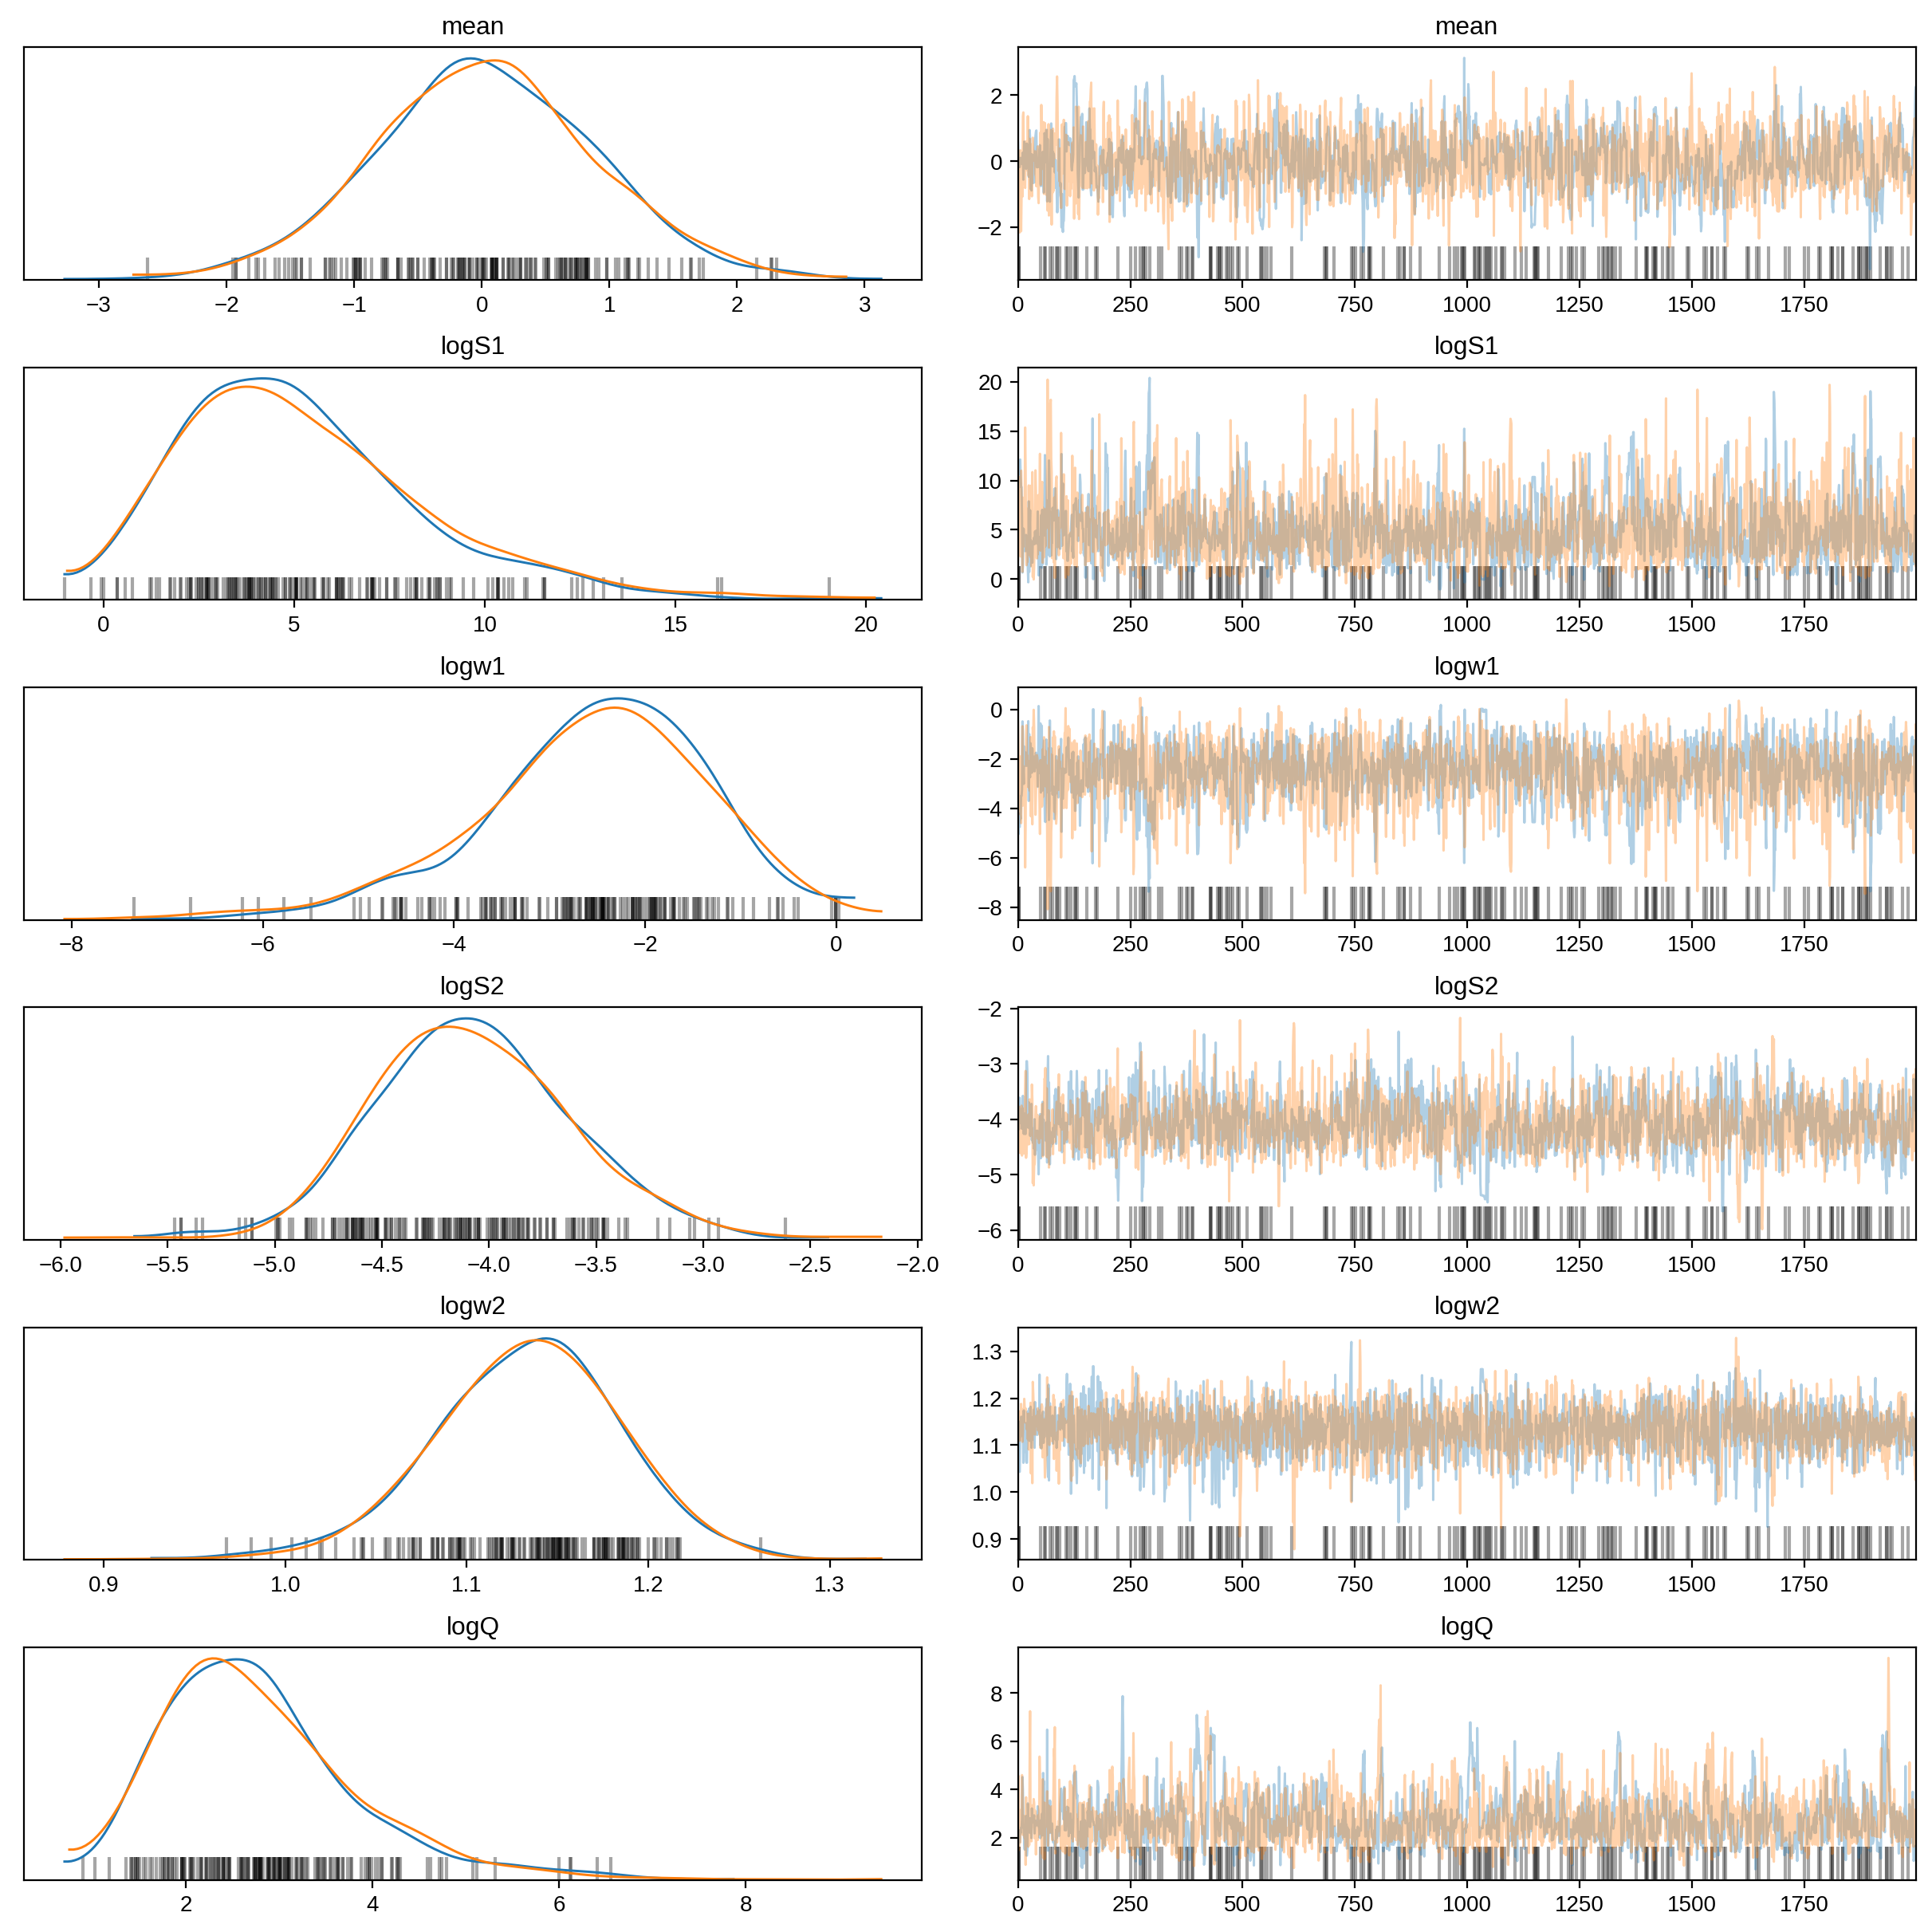

In [9]:
pm.traceplot(trace)
pm.summary(trace)

That all looks pretty good, but I like to make two other results plots: (1) a [corner plot](https://corner.readthedocs.io) and (2) a posterior predictive plot.

The corner plot is easy using `pymc3.trace_to_dataframe` and I find it useful for understanding the covariances between parameters when debugging.

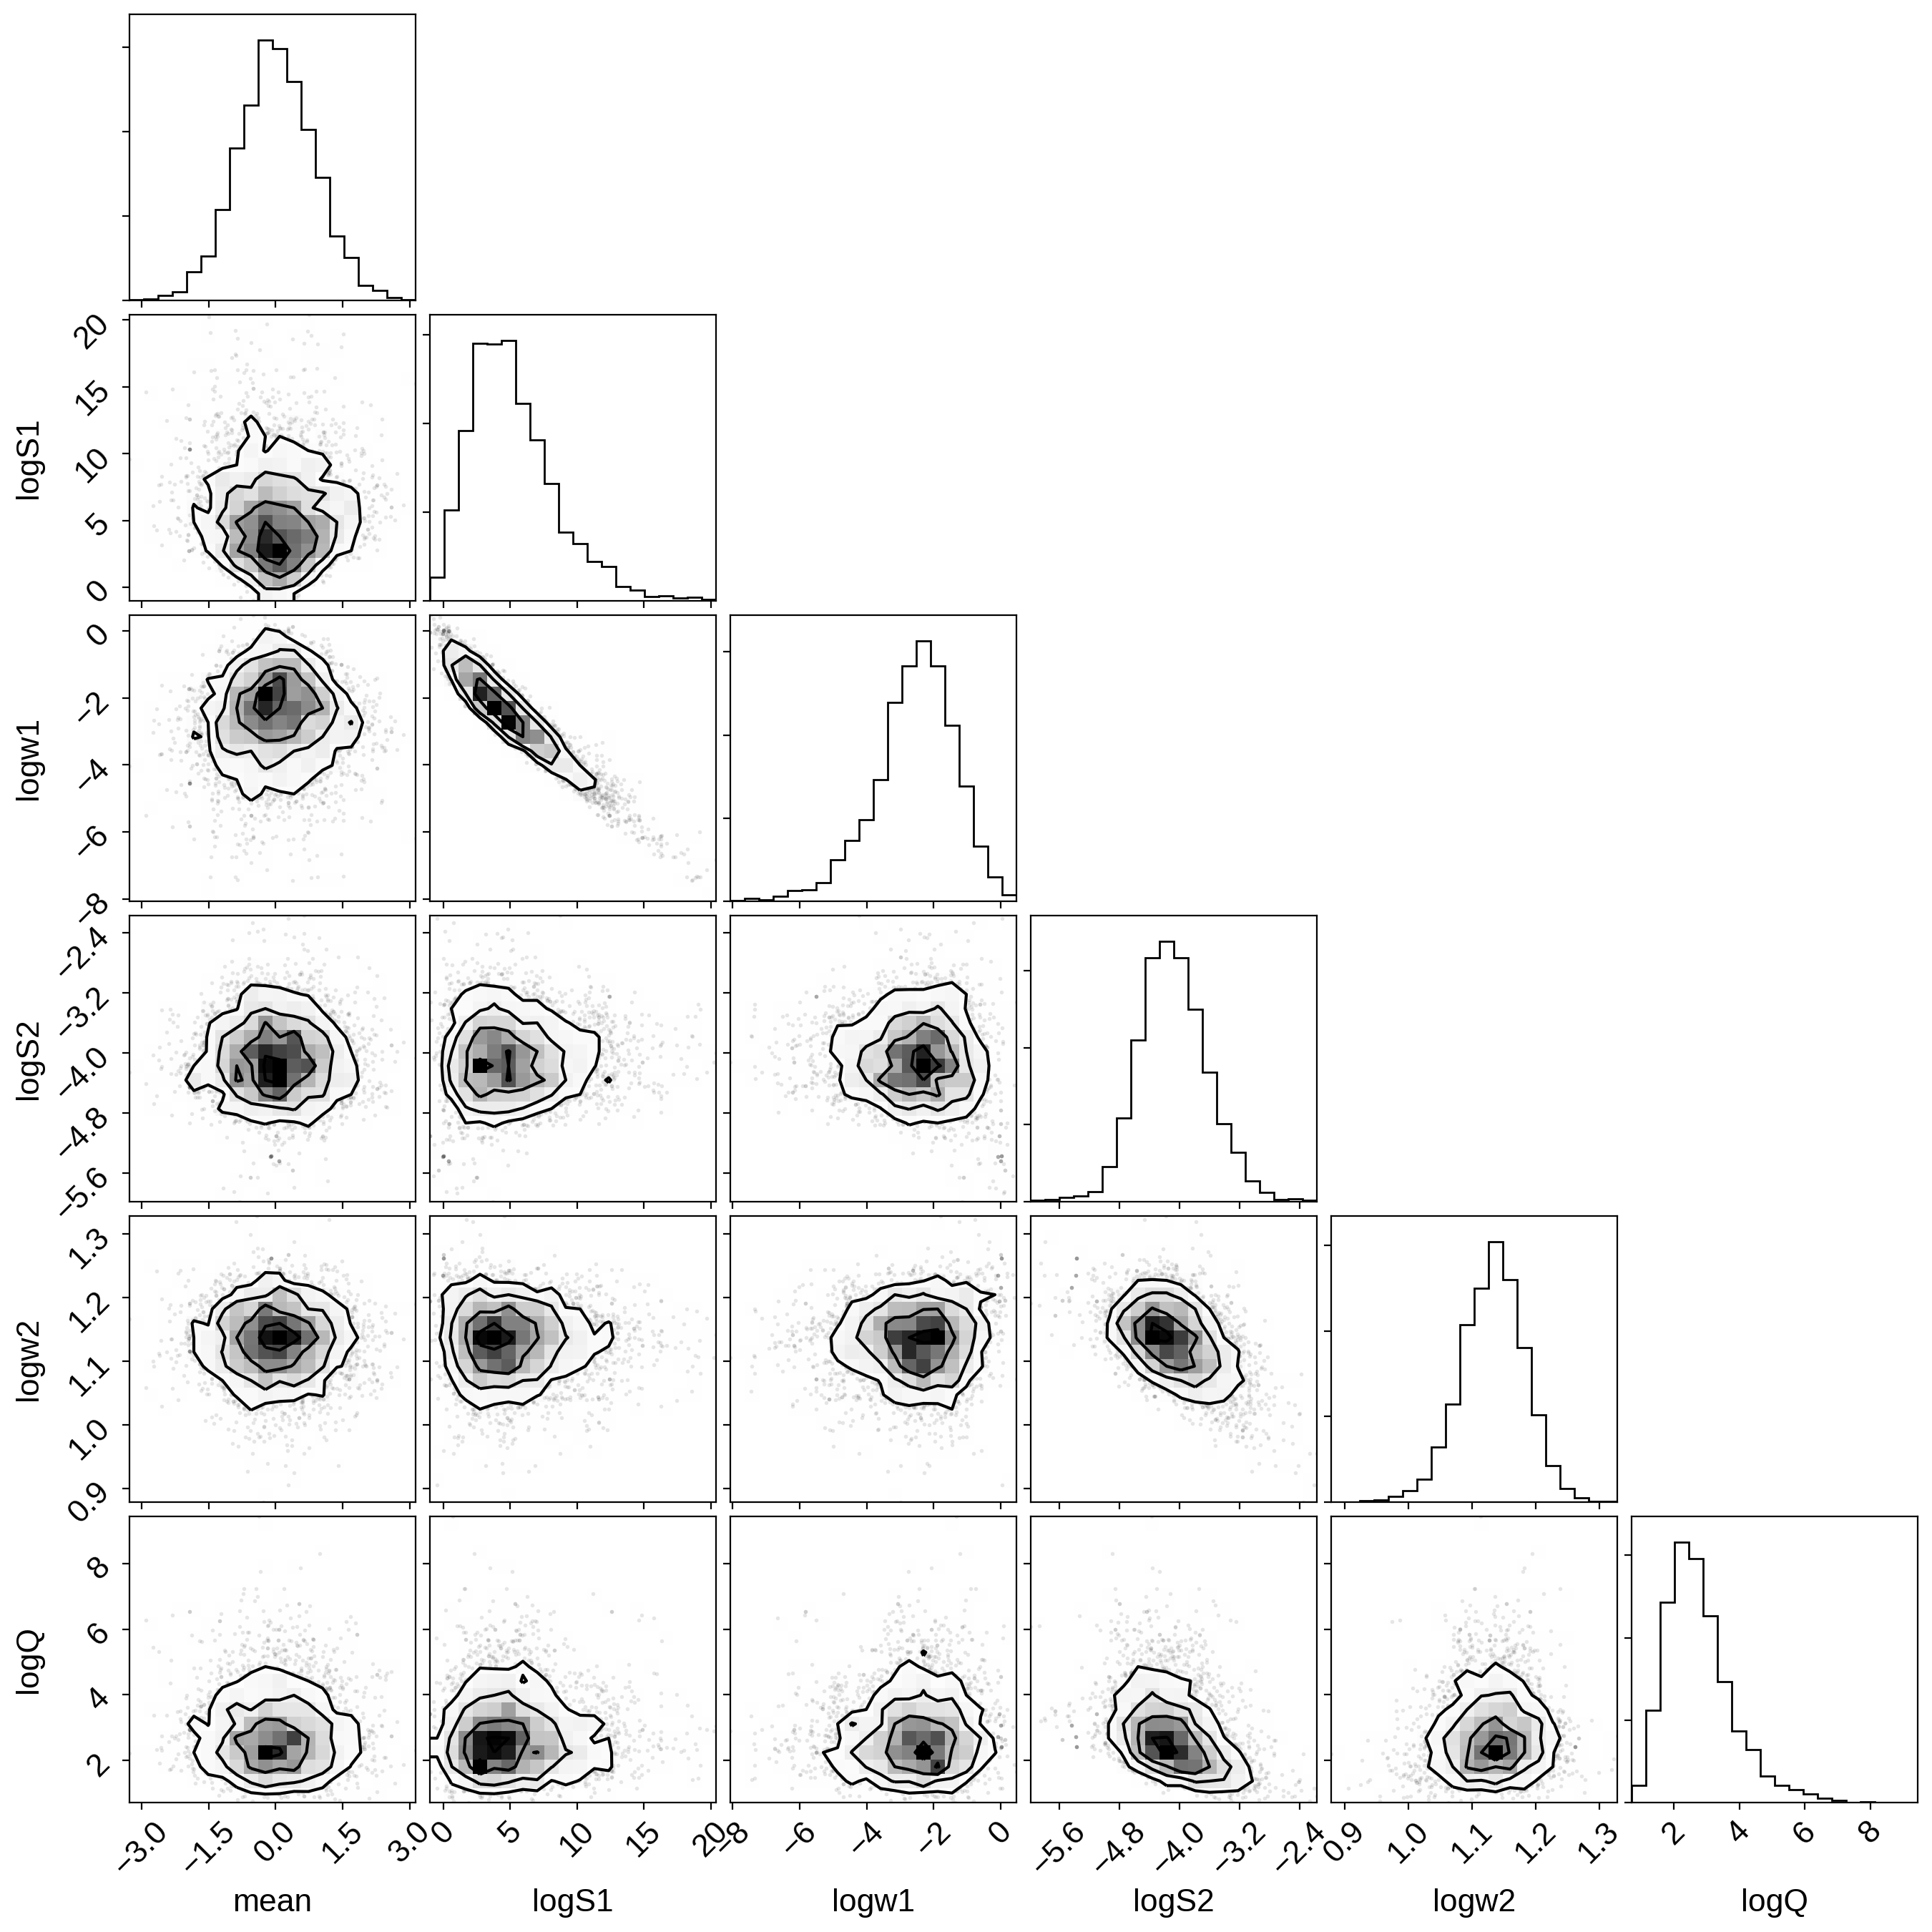

In [10]:
import corner

samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

The "posterior predictive" plot that I like to make isn't the same as a "posterior predictive check" (which can be a good thing to do too).
Instead, I like to look at the predictions of the model in the space of the data.
We could have saved these predictions using a `pymc3.Deterministic` distribution, but that adds some overhead to each evaluation of the model so instead, we can use :func:`exoplanet.utils.get_samples_from_trace` to loop over a few random samples from the chain and then the :func:`exoplanet.eval_in_model` function to evaluate the prediction just for those samples.

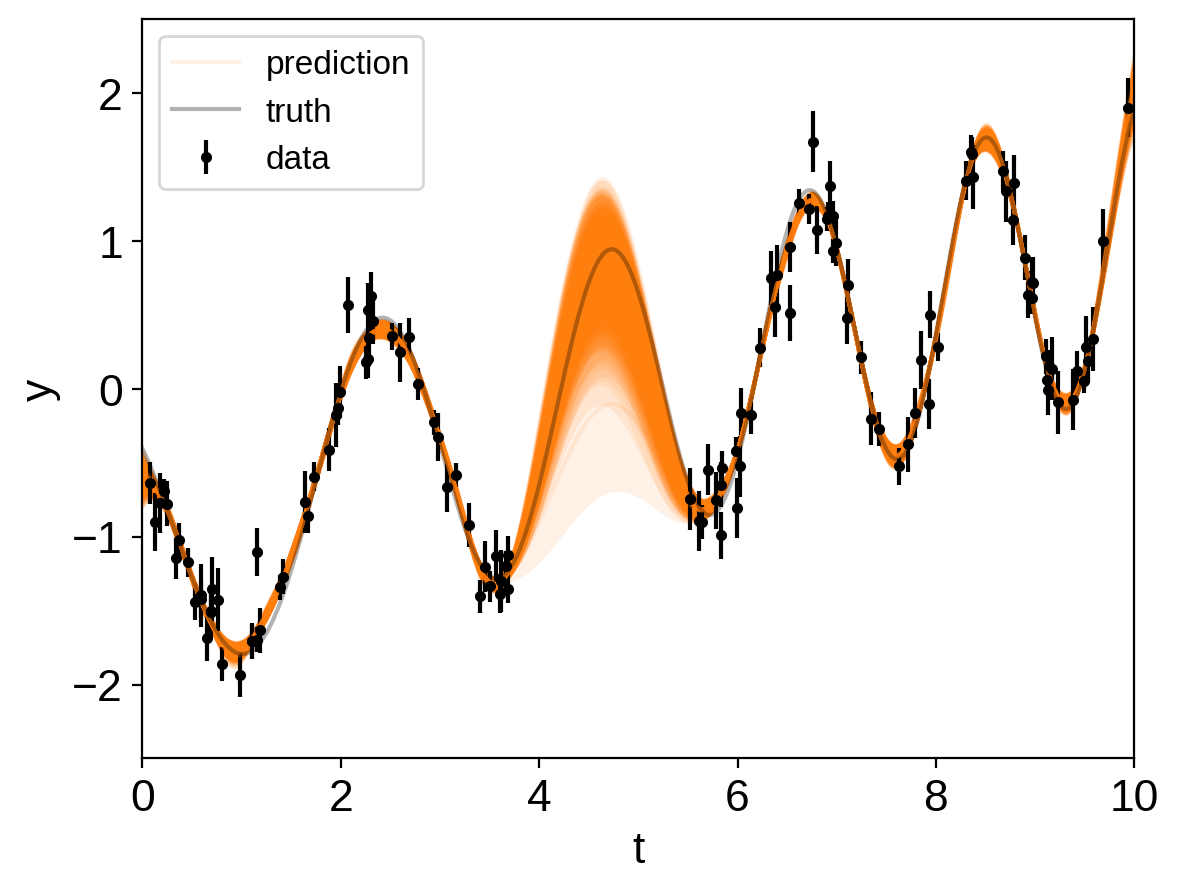

In [11]:
# Generate 50 realizations of the prediction sampling randomly from the chain
N_pred = 50
pred_mu = np.empty((N_pred, len(true_t)))
pred_var = np.empty((N_pred, len(true_t)))
with model:
    pred = gp.predict(true_t, return_var=True)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=N_pred)):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)

# Plot the predictions
for i in range(len(pred_mu)):
    mu = pred_mu[i]
    sd = np.sqrt(pred_var[i])
    label = None if i else "prediction"
    art = plt.fill_between(true_t, mu + sd, mu - sd, color="C1", alpha=0.1)
    art.set_edgecolor("none")
    plt.plot(true_t, mu, color="C1", label=label, alpha=0.1)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.legend(fontsize=12, loc=2)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.4},
   month = dec,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
